# Remake Figure 6

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20240419

This notebook is designed to reproduce figures from the paper using the archived data folder. Each section should be possible to run independently.

Note that this notebook is primarily intended for users who wish to replot the existing data in different ways; it does not include code for the analysis itself.

In [1]:
import itertools
import math
import numpy as np
import os
import pandas as pd
import pathlib
import pickle
import scipy.stats
import seaborn as sns
import sys
import time
from tqdm.notebook import tqdm

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [ ]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('E:\\','parresgold_2023_dimer_networks','parresgold_2023_dimer_networks_data'))

In [4]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [5]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [6]:
# Suppress warnings from seaborn for trying to plot too many points in a swarm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [7]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

C:\Users\jacob\AppData\Local\Temp\ipykernel_29840\3780498324.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Load Data

In [14]:
# Load summary data
summary_df = pd.read_csv(pathlib.Path(load_dir,'optimization_trials_randomK_1D','summary.csv'))

# Downcast some columns to integers for clarity
summary_df = summary_df.astype({"m": int, "targetID": int, "KID": int, "dimerID": int})

summary_df.head()
# NOTE: the "goodenough" metric is Linf <= 1.0

,m,targetID,KID,dimerID,Linf,MSE,goodenough
0,9,160,34,32,3.118270,2.008821,False
1,11,93,28,35,0.328246,0.007630,True
2,8,629,42,29,5.297338,56.355328,False
3,12,50,21,15,1.636138,1.239475,False
4,8,369,32,28,0.121195,0.001146,True


In [15]:
m_list = list(np.sort(np.unique(summary_df['m'])))
num_targets_by_m = [len(np.unique(summary_df[summary_df['m']==m]['targetID'])) for m in m_list] # Recall that not all unique functions were used as targets
num_Ks_by_m = [len(np.unique(summary_df[summary_df['m']==m]['KID'])) for m in m_list]

In [16]:
with open(str(pathlib.Path(load_dir,'optimization_trials_randomK_2D','20240826_20M_networks','optimization_trials_randomK_2D_data.pkl')), 'rb') as file:
    optimization_trials_randomK_2D_data = pickle.load(file)

In [17]:
summary_df_2D = pd.read_csv(str(pathlib.Path(load_dir,'optimization_trials_randomK_2D','20240826_20M_networks','optimization_trials_randomK_2D_summary.csv')))
# Filter out the A!=B target
summary_df_2D = summary_df_2D[summary_df_2D['targetID']!='AneqB']
summary_df_2D.head()

,m,targetID,KID,dimerID,monomerInputID,Linf,MSE,goodenough,relative_L2,relative_Linf,Hausdorff_distance,Pearson_correlation_coefficient,SSIM,Wasserstein_distance_W2_2D,Cosine_similarity
0,20,AeqB,3,None,[0 1],0.577105,0.090724,True,0.029535,0.192368,0.577973,0.986745,0.953109,0.109305,0.999565
1,20,ANOTB,7,None,[0 1],0.763150,0.216084,True,0.050719,0.254383,1.168010,0.990594,0.956361,0.109790,0.998714
2,20,NAND,8,None,[0 1],1.707790,6.265293,False,0.417176,0.569263,3.779507,0.561775,0.299484,0.629535,0.909035
3,20,OR,1,None,[0 1],0.472013,0.045867,True,0.035694,0.157338,0.532321,0.997822,0.991041,0.005508,0.999366
4,20,DoubleBandpass,0,None,[0 1],2.000000,1.841696,False,0.134372,0.666667,2.140089,0.620065,0.352064,2.222905,0.990942


Plotting functions:

In [18]:
def plot_boxes(df, xname, yname, 
               alpha=0.1, s=6, marker='.', 
                output_fname='',figsize=[6,6],linewidth=1,plotpoints=True,\
                scatterwidth=0.09,boxwidth=0.1):
    '''
    Makes a boxplot

    Parameters
    ----------
    df : pandas dataframe
        Dataframe containing the data to be plotted, at least with columns xname and yname
    xname : str
        Name of the column in df containing the data that will separate points on the x-axis
    yname : str
        Name of the column in df containing the data that will be plotted on the y-axis
    alpha : float, default 0.1
        Transparency of the points
    s : float, default 6
        Size of the points
    marker : str, default '.'
        Marker style
    output_fname : str, default ''
        Name of the file to save the figure to. If '', the figure is not saved.
    figsize : list, default [6,6]
        Size of the figure in height, width
    linewidth : float, default 1
        Width of the lines in the boxplot
    plotpoints : bool, default True
        Whether to plot points directly
    scatterwidth : float, default 0.09
        Width of the scatter points
    boxwidth : float, default 0.1
        Width of the boxplot

    Returns: fig, ax, boxes

    '''
    rng = np.random.default_rng()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = figsize)

    m_list = list(np.sort(np.unique(df[xname])))
    if plotpoints:
        for m in m_list:
            points = list(df[df[xname]==m][yname])
            ax.plot([m+rng.uniform(-(scatterwidth/2),scatterwidth/2) for x in points],points,marker=marker,linestyle='',color='k',markersize=s,\
                    markeredgewidth=0,alpha=alpha)
    boxes = ax.boxplot(positions = m_list,\
               x = [list(df[df[xname]==m][yname]) for m in m_list],\
              #  labels = [str(m) for m in m_list],\
               widths=boxwidth,\
               showfliers=False,
               boxprops={'linewidth':linewidth},
               whiskerprops={'linewidth':linewidth},
               medianprops={'linewidth':linewidth})

    if len(output_fname) > 0:
      fig.savefig(output_fname, format='pdf')
    # plt.show()
    return fig, ax, boxes

def plot_violins(df, xname, yname, widths=0.5, s = 6, color='gray',alpha=1, median_color='r',\
                 output_fname='',figsize=[6,6],marker='.',\
                plotpoints=True,subsample=False,showmedians=True):
    '''
    Makes a violin plot

    Parameters
    ----------
    df : pandas dataframe
        Dataframe containing the data to be plotted, at least with columns xname and yname
    xname : str
        Name of the column in df containing the data that will separate points on the x-axis
    yname : str
        Name of the column in df containing the data that will be plotted on the y-axis
    s : float, default 6
        Size of the points
    color: str, default 'gray'
    alpha : float, default 1
        Transparency of the points
    median_color : str, default 'r'
    output_fname : str, default ''
        Name of the file to save the figure to. If '', the figure is not saved.
    figsize : list, default [6,6]
        Size of the figure in height, width
    marker : str, default '.'
        Marker style
    plotpoints : bool, default True
        Whether to plot the points
    subsample : int or False, default False
        Whether to subsample the points to plot. If False, all points are plotted.
        If true, the number of points to plot is given by subsample.
    showmedians : bool, default True
    
    Returns: fig, ax
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = figsize)
    rng = np.random.default_rng()
    m_list = list(np.sort(np.unique(df[xname])))
    parts = ax.violinplot(positions = m_list,\
               dataset = [list(df[df[xname]==m][yname]) for m in m_list],\
               widths=widths,\
              #  labels = [str(m) for m in m_list],\
              showmedians=showmedians,\
              showextrema=False,\
              showmeans=False,\
    )
    for face in parts['bodies']:
      face.set_facecolor(color)
      face.set_alpha(1)
    if showmedians:
        parts['cmedians'].set_color('r')
        parts['cmedians'].set_linewidth(2)
    if plotpoints:
      for m in m_list:
        points = list(df[df[xname]==m][yname])
        # ax.plot([m+rng.normal(0,0.1) for x in points],points,marker=marker,linestyle='',color='k',markersize=s,\
        #         markeredgewidth=0,alpha=alpha)
        if type(subsample)==int and len(points)>subsample:
            points = rng.choice(points,size=subsample,replace=False)
        subsample_df = pd.DataFrame({xname:np.full((len(points),),m),yname:points})
        sns.swarmplot(data=subsample_df,x=xname,y=yname,orient='v',native_scale=True,\
            color='k',size=s,alpha=alpha,edgecolor='none',ax=ax)
    
    if showmedians:
        parts['cmedians'].set_zorder(10)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    if len(output_fname) > 0:
      fig.savefig(output_fname, format='pdf')
    # plt.show()
    return fig, ax, parts

def plot_CDF(df, xname, category, cmap,
               alpha=0.1, linewidth=2, output_fname='',figsize=[6,6],\
             inverty = False):
    '''
    Plots a cumulative distribution function (CDF)

    Parameters
    ----------
    df : pandas dataframe
        Dataframe containing the data to be plotted, at least with columns xname and category
    xname : str
        Name of the column in df containing the data that will separate points on the y-axis
    category : str
        Name of the column in df containing the data that will be used to categorize different CDFs
    cmap : matplotlib colormap
        Colormap to use for the different CDFs, or single color
    alpha : float, default 0.1
        Transparency of the lines
    linewidth : float, default 2
        Width of the lines
    output_fname : str, default ''
        Name of the file to save the figure to. If '', the figure is not saved.
    figsize : list, default [6,6]
        Size of the figure in height, width
    inverty : bool, default False
        Whether to invert the direction of the y-axis
    
    Returns: fig, ax
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = figsize)

    m_list = list(np.sort(np.unique(df[category])))
    for m_i, m in enumerate(m_list):
        points_sorted = list(df[df[category]==m][xname].sort_values())
        N = len(points_sorted)
        if inverty:
            y_vals = np.array(list(range(N))[::-1])/N
        else:
            y_vals = np.array(list(range(N)))/N
        if type(cmap)==str:
            color=cmap
        else:
            color=cmap(m_i/len(m_list))
        ax.plot(points_sorted,y_vals,marker='',linestyle='-',linewidth=linewidth, color=color,alpha=alpha)

    ax.set_xlabel(xname)
    ax.set_ylabel('Proportion')

    if len(output_fname) > 0:
      fig.savefig(output_fname, format='pdf')
    # plt.show()
    return fig, ax

def plot_histogram(df, xname, category, cmap,
                   bins=None,num_bins=30,style='stairs',barwidth=None,normalize=True,
               alpha=0.1, linewidth=2, output_fname='',figsize=[6,6]):

    '''
    Plots a histogram

    Parameters
    ----------
    df : pandas dataframe
        Dataframe containing the data to be plotted, at least with columns xname and category
    xname : str
        Name of the column in df containing the data that will separate points on the y-axis
    category : str
        Name of the column in df containing the data that will be used to categorize different CDFs
    cmap : matplotlib colormap or str
        Colormap to use for the different CDFs, or single color (str)
    bins : list, optional
        Bins to use for the histogram, as list of bin edges. If None, bins are automatically generated.
    num_bins : int, optional, default 30
        Number of bins to use if bins is None
    style : 'stairs' or 'bars', default 'stairs'
    barwidth : float
        Width of the bars if style is 'bars'
    normalize : bool, optional, default True
        Whether to normalize the histogram as frequencies instead of counts
    alpha : float, default 0.1
        Transparency of the lines
    linewidth : float, default 2
        Width of the lines
    output_fname : str, default ''
        Name of the file to save the figure to. If '', the figure is not saved.
    figsize : list, default [6,6]
        Size of the figure in height, width
    
    Returns: fig, ax
    '''
    if style=='bars' and barwidth is None:
        barwidth = 0.8*(bins[1:]-bins[:-1])
    if bins is None:
        bins = np.linspace(round(df[xname].min()),round(df[xname].max()),num_bins,endpoint=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = figsize)

    m_list = list(np.sort(np.unique(df[category])))
    for m_i, m in enumerate(m_list):
        points = list(df[df[category]==m][xname])
        hist,_ = np.histogram(points,bins =  bins,density=False) 
        if normalize:
            hist = hist / np.sum(hist)
        if type(cmap)==str:
            color=cmap
        else:
            color=cmap(m_i/len(m_list))
        if style=='stairs':
            ax.stairs(hist,bins,color=cmap(m_i/len(m_list)),linewidth=linewidth,alpha=alpha)
        elif style=='bars':
            ax.bar(bins[:-1],hist,width=barwidth,color=color,alpha=alpha)

    ax.set_xlabel(xname)
    ax.set_ylabel('Proportion')
    if len(output_fname) > 0:
      fig.savefig(output_fname, format='pdf')
    # plt.show()
    return fig, ax

def plot_boxes_grouped(df, xname, yname, category, cmap, category_order=None, output_fname='',\
                       figsize=[12,6],marker='.',s = 6, alpha=1,linewidth=1,plotpoints=True):
    '''
    Plots a grouped boxplot

    Parameters
    ----------
    df : pandas dataframe
        Dataframe containing the data to be plotted, at least with columns xname, yname and category
    xname : str
        Name of the column in df containing the data that will separate points on the x-axis
    yname : str
        Name of the column in df containing the data that will separate points on the y-axis
    category : str
        Name of the column in df containing the data that will be used to categorize different boxplots
    cmap : matplotlib colormap or str
        Colormap to use for the different boxplots, or single color (str)
    category_order : list, optional
        Order in which to plot the different categories
    output_fname : str, default ''
        Name of the file to save the figure to. If '', the figure is not saved.
    figsize : list, default [12,6]
        Size of the figure in height, width
    marker : str, default '.'
        Marker to use for the points
    s : float, default 6
        Size of the points
    alpha : float, default 1
        Transparency of the points
    linewidth : float, default 1
        Width of the lines in the boxplot
    plotpoints : bool, default True
        Whether to plot points directly
    
    Returns: fig, ax
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = figsize)
    m_list = list(np.sort(np.unique(df[xname])))
    rng = np.random.default_rng()
    if category_order is None:
        category_order = list(np.unique(df[category]))
    width_per_category_item = 0.6/len(category_order)
    category_positions = np.linspace(-0.4+(width_per_category_item/2),0.4-(width_per_category_item/2),len(category_order),endpoint=True)
    for category_i, category_item in enumerate(category_order):
        if plotpoints:
            for m in m_list:
                points = list(df[(df[xname]==m)&(df[category]==category_item)][yname])
                ax.plot([m+category_positions[category_i]+rng.uniform(-(width_per_category_item/2),(width_per_category_item/2)) for x in points],\
                        points,marker='.',linestyle='',color=cmap(category_i),markersize=s,\
                        markeredgewidth=0,alpha=alpha)
        boxplots = ax.boxplot(positions = np.array(m_list)+category_positions[category_i],\
                x = [list(df[(df[xname]==m)&(df[category]==category_item)][yname]) for m in m_list],\
                #  labels = [str(m) for m in m_list],\
                widths=width_per_category_item,\
                patch_artist=True,\
                showfliers=False,
               boxprops={'linewidth':linewidth},
               whiskerprops={'linewidth':linewidth},
               medianprops={'linewidth':linewidth})
        for patch in boxplots['boxes']:
            patch.set_facecolor(cmap(category_i))
            patch.set_alpha(0.3)
        for patch in boxplots['medians']:
            patch.set_color('k')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    if len(output_fname) > 0:
        fig.savefig(output_fname, format='pdf')
    # plt.show()
    return fig, ax

def plot_violins_grouped(df, xname, yname, category, cmap, category_order=None,\
                         output_fname='',figsize=[12,6],marker='.',s = 6, alpha=1,plotpoints=True,\
                         showmedians=True):
    '''
    Plots a grouped violinplot

    Parameters
    ----------
    df : pandas dataframe
        Dataframe containing the data to be plotted, at least with columns xname, yname and category
    xname : str
        Name of the column in df containing the data that will separate points on the x-axis
    yname : str
        Name of the column in df containing the data that will separate points on the y-axis
    category : str
        Name of the column in df containing the data that will be used to categorize different violinplots
    cmap : matplotlib colormap or str
        Colormap to use for the different violinplots, or single color (str)
    category_order : list, optional
        Order in which to plot the different categories
    output_fname : str, default ''
        Name of the file to save the figure to. If '', the figure is not saved.
    figsize : list, default [12,6]
        Size of the figure in height, width
    marker : str, default '.'
        Marker to use for the points
    s : float, default 6
        Size of the points
    alpha : float, default 1
        Transparency of the points
    showmedians : bool, default True
        Whether to show the median line
    
    Returns: fig, ax
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = figsize)

    m_list = list(np.sort(np.unique(df[xname])))
    rng = np.random.default_rng()
    if category_order is None:
        category_order = list(np.unique(df[category]))
    width_per_category_item = 0.6/len(category_order)
    category_positions = np.linspace(-0.4+(width_per_category_item/2),0.4-(width_per_category_item/2),len(category_order),endpoint=True)
    for category_i, category_item in enumerate(category_order):
        for m in m_list:
          if plotpoints:
            points = list(df[(df[xname]==m)&(df[category]==category_item)][yname])
            ax.plot([m+category_positions[category_i]+rng.uniform(-(width_per_category_item/2),(width_per_category_item/2)) for x in points],\
                    points,marker=marker,linestyle='',color=cmap(category_i),markersize=s,\
                    markeredgewidth=0,alpha=alpha)
            if len(points)==0:
              continue
          parts = ax.violinplot(positions = [m+category_positions[category_i]],\
                    dataset = [list(df[(df[xname]==m)&(df[category]==category_item)][yname])],\
                    #  labels = [str(m) for m in m_list],\
                    showmedians=showmedians,\
                    showextrema=False,\
                    showmeans=False,\
                    widths=width_per_category_item,\
          )
          for face in parts['bodies']:
            face.set_facecolor(cmap(category_i))
            face.set_alpha(0.3)
          if showmedians:
            parts['cmedians'].set_color('k')
            parts['cmedians'].set_linewidth(2)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    if len(output_fname) > 0:
      fig.savefig(output_fname, format='pdf')
    # plt.show()
    return fig, ax, parts


def moving_average(x_vals, y_vals, window_size=None, num_windows=50):
    if window_size is None:
        x_range = np.max(x_vals) - np.min(x_vals)
        window_size = x_range/5
    x_window_centers = np.linspace(np.min(x_vals),np.max(x_vals),\
                                   num_windows,endpoint=True)
    x_window_means = [(x, np.mean(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])) \
                        if len(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])>0\
                        else (x, np.nan) \
                        for x, window in zip(x_window_centers,range(num_windows))]
    return np.array(x_window_means)

def binned_average(x_vals, y_vals, log_x=True, log_y=True, extent=None, x_bin_size=None, num_x_bins=None,\
                    min_points=10, summary_stat_function=np.mean):
    '''
    Bins and summarizes y_vals based on x_vals. 

    Parameters
    ----------
    x_vals,y_vals : 1D arrays
        Data
    log_x, log_y : bool
        Whether to log transform the x and y data. Default True.
    extent : tuple
        (xmin,xmax) to use for defining bins. If None, uses min and max of x_vals.
        If log_x is True, extent should be in log space.
    x_bin_size : float, optional
        Size of bins. If None, uses num_x_bins to calculate.
    num_x_bins : int, optional
        Number of bins. If None, uses x_bin_size to calculate. Defaults to 50.
    min_points : int
        If fewer than min_points are in a bin, np.nan is returned instead. Defaults to 10.
    summary_stat_function : function
        Function to summarize y_vals in a bin. Defaults to np.mean.

    Returns
    -------
    x_bin_centers : array
        Centers of bins
    bin_means : array
        Summary statistic of y_vals in each bin
    '''
    if log_x:
        if log_y:
            x_vals,y_vals = x_vals[np.where((x_vals>0)&(y_vals>0))], y_vals[np.where((x_vals>0)&(y_vals>0))]
            x_vals, y_vals = np.log10(x_vals), np.log10(y_vals)
        else:
            x_vals = x_vals[np.where(x_vals>0)]
            x_vals = np.log10(x_vals)
    if log_y and (not log_x):
        y_vals = y_vals[np.where(y_vals>0)]
        y_vals = np.log10(y_vals)
    if extent is None:
        if log_x:
            xmin = math.floor(np.log10(np.nanmin(x_vals)))
            xmax = math.ceil(np.log10(np.nanmax(x_vals)))
        else:
            xmin = np.nanmin(x_vals)
            xmax = np.nanmax(x_vals)
            incremement = 10**math.floor(np.log10(np.abs(xmin)))
            xmin = incremement*math.floor(xmin/incremement)
            xmax = incremement*math.ceil(xmax/incremement)
        
        if log_y:
            ymin = math.floor(np.log10(np.nanmin(y_vals)))
            ymax = math.ceil(np.log10(np.nanmax(y_vals)))
        else:
            ymin = np.nanmin(y_vals)
            ymax = np.nanmax(y_vals)
            incremement = 10**math.floor(np.log10(np.abs(ymin)))
            ymin = incremement*math.floor(ymin/incremement)
            ymax = incremement*math.ceil(ymax/incremement)
    else:
        xmin = extent[0]
        xmax = extent[1]
    if x_bin_size is None:
        if num_x_bins is None:
            num_x_bins=50
        x_bin_size = (xmax-xmin)/num_x_bins
    elif num_x_bins is None:
        num_x_bins = (xmax-xmin)/x_bin_size
    x_bin_centers = np.linspace(xmin,xmax,num_x_bins,endpoint=True)
    bin_means = np.zeros((num_x_bins,))
    for x_bin in range(num_x_bins):
        subset = y_vals[np.where((x_vals>=x_bin_centers[x_bin]-(x_bin_size/2))&\
                                                (x_vals<=x_bin_centers[x_bin]+(x_bin_size/2)))[0]]
        if len(subset)>=min_points:
            bin_means[x_bin] = summary_stat_function(subset)
        else:
            bin_means[x_bin] = np.nan
    return x_bin_centers,bin_means

def savefig_pdf_png(fig, plotdir,filename):
    plt.figure(fig)
    plt.savefig(os.path.join(plotdir, filename+'.pdf'),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(os.path.join(plotdir, filename+'.png'),dpi=900,bbox_inches='tight')


## Figure 6A: Random Network Schematic

In [ ]:
m = 6
num_inputs = 1
name = f'{m}M_random'

rng = np.random.default_rng()

# Affinities
num_dimers = int(num_combos_with_replacement(m,2))
# K = 10**rng.uniform(-4,0,size=num_dimers)

K = np.array([1.99024420e-01, 2.59750078e-02, 4.22457698e-03, 3.23810987e-02,
       1.93835365e-01, 4.11499807e-04, 8.49920441e-04, 3.10086257e-01,
       1.41268438e-02, 3.81204362e-03, 1.23190026e-03, 2.62164049e-03,
       6.45243086e-04, 4.74816893e-03, 1.44019353e-04, 2.98439313e-01,
       4.09016015e-03, 3.53352356e-03, 1.02324243e-04, 1.33585451e-01,
       6.72845995e-04])

# Accessory expression levels
A = np.full((m-num_inputs,),1)

param_sets = np.expand_dims(np.hstack((K,A)),axis=0)

dimer_of_interest = make_nXn_species_names(m).index('D_1_1') - m # Index of dimer to use as output (D_1_1 = index 0)

In [ ]:
save = True

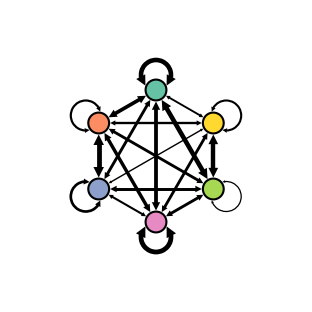

In [ ]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]), # Index of output dimer
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.22, # Radius of nodes around center
                                        r_loop = 0.05, # Radius of loops around nodes 
                                        node_scales = [-3,3,5.5,5.5], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,0.3,2], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='k',
                                        labels=False,
                                        upscale_arrowhead=1.1,
                                        node_edge_width=0.5,
)

fig.set_dpi(300)

if save:
    filename = f'Fig6A_{name}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)

## Figure 6B: Single-Dimer, random K Versatility

Versatility across network sizes based on optimization trials

In [18]:
# Examine fits by treating all (K, dimer) pairs as independent systems

# for each m, what fraction of expressible targets can be achieved using a random K, a random output dimer, and a tuned a
versatility_singledimer_df = summary_df.groupby(['m','KID', 'dimerID'],as_index=False)['goodenough'].agg('sum')
for m_i, m in enumerate(m_list):
    indices = versatility_singledimer_df[versatility_singledimer_df['m']==m].index
    versatility_singledimer_df.loc[indices,'goodenough'] = versatility_singledimer_df.loc[indices,'goodenough']/num_targets_by_m[m_i]

versatility_singledimer_df.head()

,m,KID,dimerID,goodenough
0,2,0,0,0.1250
1,2,0,1,0.0625
2,2,0,2,0.1250
3,2,1,0,0.1250
4,2,1,1,0.0625


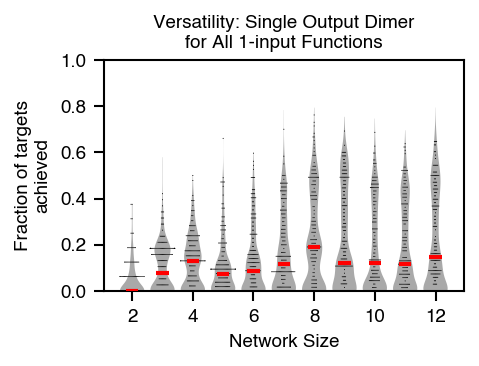

In [19]:
save = True

# Make violin plot
fig, ax, parts = plot_violins(versatility_singledimer_df, xname='m', yname='goodenough',\
                                     figsize=(3.1,2),plotpoints=True,s=0.5,alpha=1,subsample=200,\
                                        widths=0.8,color='darkgray')
_ = ax.set_xlabel('Network Size',fontsize=9)
_ = ax.set_ylabel('Fraction of targets\nachieved',fontsize=9)
_ = ax.set_title('1-input Versatility:\nSingle Output Dimer for All Functions',fontsize=9)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

_ = ax.set_ylim([0,1])

if save:
    filename = f'Fig6B_singledimer_versatility_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Figure 6C: Any-Dimer, random K Versatility

Expressivity of random interactions, across network sizes, based on optimization trials

In [20]:
m_list = list(np.sort(np.unique(summary_df['m'])))
num_targets_by_m = [len(np.unique(summary_df[summary_df['m']==m]['targetID'])) for m in m_list] # Recall that not all unique functions were used as targets
num_Ks_by_m = [len(np.unique(summary_df[summary_df['m']==m]['KID'])) for m in m_list]

In [21]:
## Examine expressivity when maxing over output dimer

# This step assigns assigns an (m, KID, targetID) pair the maximum value of "goodenough" available over all its "dimerID" values
versatility_anydimer_df = summary_df.groupby(['m','KID','targetID'],as_index=False)['goodenough'].agg('max').reset_index(drop=True)

# Compute the library efficiency of each (m, KID) pair by looking at the fraction of library it is "goodenough" for.
versatility_anydimer_df = versatility_anydimer_df.groupby(['m','KID'],as_index=False)['goodenough'].agg('sum')
for m_i, m in enumerate(m_list):
    indices = versatility_anydimer_df[versatility_anydimer_df['m']==m].index
    versatility_anydimer_df.loc[indices,'goodenough'] = versatility_anydimer_df.loc[indices,'goodenough']/num_targets_by_m[m_i]

versatility_anydimer_df.head()

,m,KID,goodenough
0,2,0,0.3125
1,2,1,0.1875
2,2,2,0.1250
3,2,3,0.2500
4,2,4,0.0000


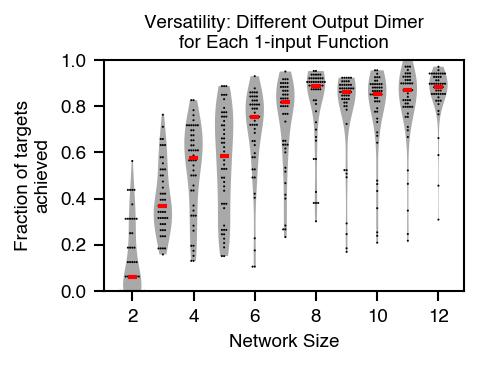

In [22]:
save = True

# Make violin plot
fig, ax, parts = plot_violins(versatility_anydimer_df, xname='m', yname='goodenough', marker='.',\
                             alpha=1, s=1,figsize=(3.1,2),plotpoints=True,subsample=200,\
                            color='darkgray',widths=0.6)

_ = ax.set_xlabel('Network Size',fontsize=9)
_ = ax.set_ylabel('Fraction of targets\nachieved')
_ = ax.set_title('1-input Versatility:\nDifferent Output Dimer for Each Function',fontsize=9)
_ = ax.set_ylim([0,1])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

if save:
    filename = f'Fig6C_anydimer_versatility_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Figure 6D: Example of 2-input, random K versatility

The best was KID=4. We will probably take the axes labels and colorbar from Figure 4C.

In [471]:
KIDs_to_plot = [4]
# KIDs_to_plot = np.sort(np.unique(summary_df_2D['KID']))
# targets_to_plot = np.sort(np.unique(summary_df_2D['targetID']))
targets_to_plot = np.array(['ratio','NOR', 'OR','ANOTB','AND','NAND','XNOR','XOR','AeqB', 'DoubleBandpass']) # Re-order

In [472]:
targets_to_plot_labels =['Ratio','NOR', 'OR','NIMPLY','AND','NAND','XNOR','XOR','A=B', '2-input Bump']

In [467]:
t=12 # Number of input titration points, in each dimension
input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

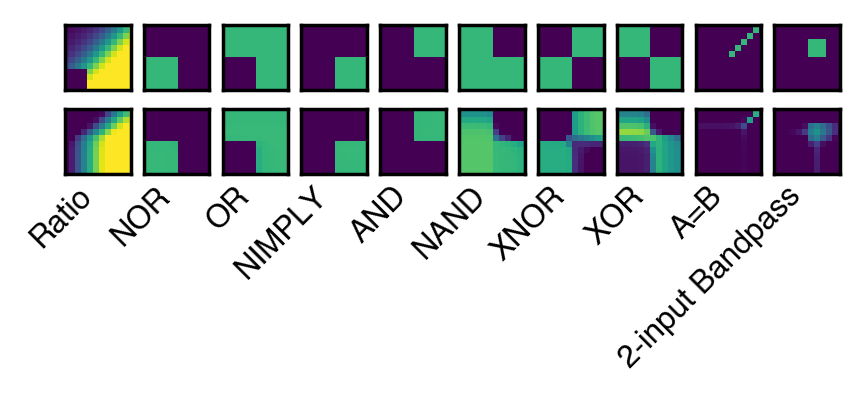

In [473]:
save = True

fig_height_inches = (len(KIDs_to_plot)+1)*0.4
fig_width_inches = len(targets_to_plot)*0.4

fig, axs = plt.subplots(nrows=len(KIDs_to_plot)+1,ncols=len(targets_to_plot),figsize=(fig_width_inches,fig_height_inches),sharex=True,sharey=True,\
                        # gridspec_kw={'left':0.075,'right':0.925,'hspace': 0.1, 'wspace': 0.1}
                        )

cmap = plt.get_cmap('viridis')

x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

# out_range = [10**input_lb,10**input_ub]
out_range = [10**input_lb,10**0]

for col, targetID in enumerate(targets_to_plot):
    # Plot target in first row
    row = 0
    target = 10**optimization_trials_randomK_2D_data[f'm-20_targetID-{targetID}_KID-{1}_dimerID-None']['f_target']
    matrix = axs[row,col].pcolormesh(x_points,x_points,target.reshape((t,t)).T,\
                                        cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                        shading = 'nearest',rasterized=False)
            # shading='gouraud' or shading='nearest'
    for row, KID in enumerate(KIDs_to_plot):
        row +=1 # First row is for the target itself
        # Need to take transpose so that M1 appears on X-axis
        response = 10**optimization_trials_randomK_2D_data[f'm-20_targetID-{targetID}_KID-{KID}_dimerID-None']['f_fit']
        matrix = axs[row,col].pcolormesh(x_points,x_points,response.reshape((t,t)).T,\
                                        cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                        shading = 'nearest',rasterized=False)
            # shading='gouraud' or shading='nearest'

for col in range(len(targets_to_plot)):
    for row in range(len(KIDs_to_plot)+1):
        axs[row,col].xaxis.set_ticks_position("bottom")
        axs[row,col].set_xscale('log')
        axs[row,col].set_yscale('log')
        # axs[row,col].set_xlabel(f'Input M1')
        # axs[row,col].set_ylabel(f'Input M2')
        axs[row,col].set_aspect(1) # Ensure that plot area is a perfect square
        axs[row,col].set_xlim([10**input_lb,10**input_ub])
        axs[row,col].set_ylim([10**input_lb,10**input_ub])
        # Customize spines
        set_spine_linewidth(axs[row,col],1)

        # Set ticks
        axs[row,col].tick_params(axis='both', which='both', bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False)  
        # if col==0:
        #     set_simple_log_ticks(axs[row,col],which='y',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)
        # else:
        #     axs[row,col].set_yticklabels([])
        # if row==len(KIDs_to_plot):
        #     set_simple_log_ticks(axs[row,col],which='x',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)
        # else:
        #     axs[row,col].set_xticklabels([])
        # Customize the major ticks
        # axs[row,col].tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks
        # Customize the minor ticks
        # axs[row,col].tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks
        # axs[row,col].xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
        # axs[row,col].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))


# _ = fig.supxlabel('Input M1',fontsize=9,y=0.015)
# _ = fig.supylabel('Input M2',fontsize=9)

for col, targetID in enumerate(targets_to_plot):
    axs[-1, col].text(0.5, -0.1, f'{targets_to_plot_labels[col]}', va='top', ha='right', transform=axs[-1, col].transAxes, fontsize=9,rotation=45)

fig.set_dpi(250)

if save:
    filename = f'Fig6D_2D_versatility_example'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [440]:
m = 20
num_inputs = 2

targetID = 'XNOR'
KID = 4

K = optimization_trials_randomK_2D_data[f'm-20_targetID-{targetID}_KID-{KID}_dimerID-None']['K']
# A = 10**optimization_trials_randomK_2D_data[f'm-20_targetID-{targetID}_KID-{KID}_dimerID-None']['a']
A = np.full((m-num_inputs,),1)

param_sets = np.expand_dims(np.hstack((K,A)),axis=0)

# dimer_of_interest = np.where(optimization_trials_randomK_2D_data[f'm-20_targetID-{targetID}_KID-{KID}_dimerID-None']['theta'])[0][0]

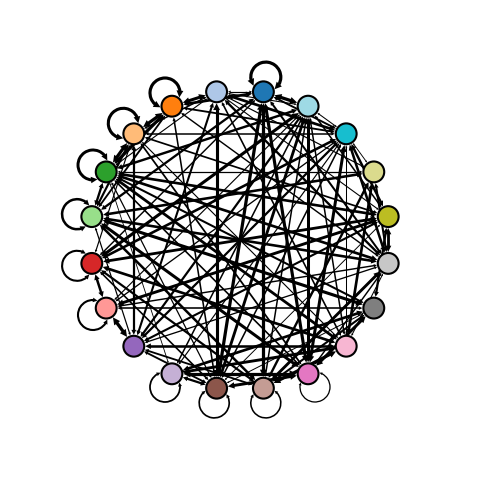

In [461]:
save = True

# cmap = plt.get_cmap('hsv')
# custom_cmap = mcolors.ListedColormap([cmap(i/m) for i in range(m)])

fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=num_inputs, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        # dimers_of_interest=np.array([[dimer_of_interest]]), # Index of output dimer
                                        dimers_of_interest=None, # Index of output dimer
                                        input_node_values=np.array([0,0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.5, # Radius of nodes around center
                                        r_loop = 0.05, # Radius of loops around nodes 
                                        node_scales = [-3,3,5.5,5.5], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-2,7,0.2,0.8], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='tab20', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='k',
                                        labels=False,
                                        upscale_arrowhead=1.1,
                                        node_edge_width=0.5,
)

fig.set_dpi(300)

if save:
    filename = f'Fig6E_KID-{KID}_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)

## Figure 6E: 2-input, random K versatility, Pearson correlations for all K's and targets

We're going to order the rows top to bottom by number of successful functions:

In [ ]:
pearson_threshold = 0.85

summary_df_2D['goodenough_pearson'] = summary_df_2D['Pearson_correlation_coefficient']>=pearson_threshold

## Examine expressivity when maxing over output dimer
# Compute the library efficiency of each (m, KID) pair by looking at the fraction of library it is "goodenough" for.
versatility_2input_df = summary_df_2D.groupby(['m','KID'],as_index=False)['goodenough_pearson'].agg('sum')

versatility_2input_df.loc[:,'goodenough_pearson'] = versatility_2input_df.loc[:,'goodenough_pearson']/num_targets_2D

versatility_2input_df = versatility_2input_df.sort_values('goodenough_pearson',ascending=False)

KIDs_to_plot = np.array(versatility_2input_df['KID'])

# Swap 3 and 4
KIDs_to_plot = np.array([4, 3, 2, 7, 1, 8, 9, 5, 6, 0])

In [ ]:
pearson_matrix = np.zeros((len(KIDs_to_plot),len(targets_to_plot)))

# KIDs_to_plot = np.sort(np.unique(summary_df_2D['KID']))
# targets_to_plot = np.unique(summary_df_2D['targetID'])
targets_to_plot = np.array(['ratio','NOR', 'OR','ANOTB','AND','NAND','XNOR','XOR','AeqB', 'DoubleBandpass']) # Re-order

for row, KID in enumerate(KIDs_to_plot):
    for col, targetID in enumerate(targets_to_plot):
        pearson_matrix[row,col] = summary_df_2D[(summary_df_2D['KID']==KID)&(summary_df_2D['targetID']==targetID)]['Pearson_correlation_coefficient'].values[0]

In [ ]:
targets_to_plot_labels =['Ratio','NOR', 'OR','NIMPLY','AND','NAND','XNOR','XOR','A=B', '2-input Bump']

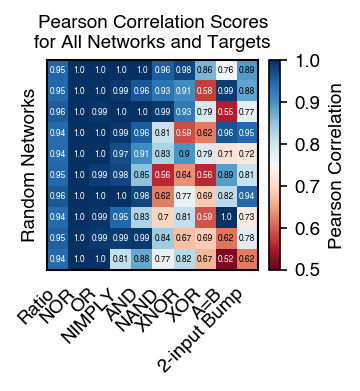

In [71]:
save = True

fig, ax = plt.subplots(figsize=(2,1.9))

cmap = plt.get_cmap('RdBu')

vmin = 0.1*(np.min(pearson_matrix)//0.1)
vmax = 1
matrix = ax.matshow(pearson_matrix,cmap = cmap,vmin=vmin,vmax=vmax)

for (j,i),label in np.ndenumerate(pearson_matrix):
    if label>(vmin+(0.2*(vmax-vmin))) and label<(vmin+(0.8*(vmax-vmin))):
        color='black'
    else:
        color='white'
    ax.text(i,j,round(label,2),ha='center',va='center',fontsize=4,color=color)

# _ = ax.set_xlabel('Target')
_ = ax.set_ylabel('Random Networks')
_ = ax.set_title(f'Pearson Correlation Scores\nfor All Networks and Targets',fontsize=9)

ax.set_xticks(list(range(len(targets_to_plot))),labels=targets_to_plot_labels,fontsize=9,rotation=45,ha='right')
ax.xaxis.set_ticks_position("bottom")

# ax.set_yticks(KIDs_to_plot,labels=KIDs_to_plot+1)
ax.set_yticks([])

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,         
    right=False,
    left=False
 )

set_spine_linewidth(ax,1)

ax.set_aspect(1)

fig.colorbar(matrix, ax=ax,label='Pearson Correlation',fraction=0.045, pad=0.05)

if save:
    filename = f'Fig6E_pearson_correlations'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Supplementary Figure S6A-1: Versatility by Network Connectivity (Single Dimer)

Versatility for one-input networks across network connectivity (based on optimization trials)

In [318]:
m = 8
m_i = m_list.index(m)

In [319]:
# Load summary data
summary_df_connectivity = pd.read_csv(pathlib.Path(load_dir,'optimization_trials_randomK_1D_testing_connectivity',\
                                      'summary.csv'))

# Downcast some columns to integers for clarity
summary_df_connectivity = summary_df_connectivity.astype({"m": int, "targetID": int, "KID": int, "dimerID": int})

summary_df_connectivity.head()
# NOTE: the "goodenough" metric is Linf <= 1.0

,m,targetID,KID,dimerID,Linf,MSE,goodenough
0,8,504,7,30,1.273760,0.287037,False
1,8,315,48,1,2.029508,1.716108,False
2,8,242,16,31,3.606999,1.116838,False
3,8,51,35,28,5.652279,8.178043,False
4,8,178,60,25,1.034363,0.342071,False


In [320]:
with open(pathlib.Path(load_dir,'optimization_trials_randomK_1D_testing_connectivity',\
                                      'K_random.pkl'), 'rb') as f:
  K_connectivity = pickle.load(f)[m]

In [321]:
# Create keys for which dimers are homodimers vs. heterodimers
edge_key = {}
homo_edges = []
hetero_edges = []

for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
    edge_key[(combo[0],combo[1])] = i
    if combo[0]==combo[1]:
        homo_edges.append(i)
    else:
        hetero_edges.append(i)

dimers_by_param_set = np.apply_along_axis(dimers_from_param_set,axis=1,arr=K_connectivity,\
                                        edges_to_count=np.arange(num_combos_with_replacement(m,2)),\
                                        min_affinity=1e-5)

edges_by_param_set = np.sum(np.apply_along_axis(dimers_from_param_set,axis=1,arr=K_connectivity,\
                                        edges_to_count=hetero_edges,\
                                        min_affinity=1e-5),axis=1)

In [322]:
# Examine fits by treating all (K, dimer) pairs as independent systems

# for each m, what fraction of expressible targets can be achieved using a random K, a random output dimer, and a tuned a
versatility_singledimer_connectivity_df = summary_df_connectivity.groupby(['m','KID', 'dimerID'],as_index=False)['goodenough'].agg('sum')

indices = versatility_singledimer_connectivity_df[versatility_singledimer_connectivity_df['m']==m].index
versatility_singledimer_connectivity_df.loc[indices,'goodenough'] = versatility_singledimer_connectivity_df.loc[indices,'goodenough']/num_targets_by_m[m_i]

# Keep only dimers with nonzero K's 
for K_i in range(K_connectivity.shape[0]):
    indices = versatility_singledimer_connectivity_df[versatility_singledimer_connectivity_df['KID']==K_i].index
    versatility_singledimer_connectivity_df = versatility_singledimer_connectivity_df.drop(indices[dimers_by_param_set[K_i]==0]).reset_index(drop=True)

versatility_singledimer_connectivity_df.head()

,m,KID,dimerID,goodenough
0,8,0,0,0.031746
1,8,0,3,0.095238
2,8,0,7,0.000000
3,8,0,8,0.253968
4,8,0,9,0.000000


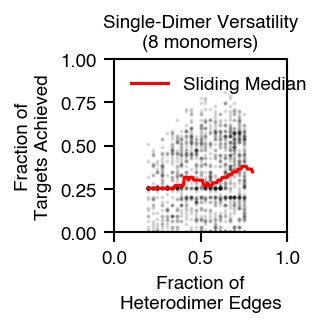

In [331]:
save = True

fig, ax = plt.subplots(figsize=(1.6,1.5))

rng = np.random.default_rng()

max_num_edges = num_combos_with_replacement(m,2)

edge_values = list(range(np.min(edges_by_param_set),np.max(edges_by_param_set)))
fraction_connectivities = [x/max_num_edges for x in edge_values]
# median_versatility_by_num_edges = []
all_x_vals = []
all_y_vals = []

for num_edges in edge_values:
    K_idx = np.where(edges_by_param_set==num_edges)[0]
    versatility_scores = versatility_singledimer_connectivity_df[versatility_singledimer_connectivity_df['KID'].isin(K_idx)]['goodenough']
    fraction_connectivity = num_edges/max_num_edges
    x_vals = [fraction_connectivity for x in range(len(versatility_scores))]
    ax.plot(x_vals,versatility_scores,marker='.',ls='',color='k',markersize=2,alpha=0.1)
    # median_versatility_by_num_edges.append(np.median(versatility_scores))
    all_x_vals.extend(x_vals)
    all_y_vals.extend(versatility_scores)

# versatility_movingaverage = moving_average(x_vals=np.array(all_x_vals), y_vals=np.array(all_y_vals), window_size=3, num_windows=50)
# ax.plot(versatility_movingaverage.T[0],versatility_movingaverage.T[1],linestyle='-',marker='',color='r')

# Plot sliding window average
x_bin_centers,versatility_movingaverage = binned_average(np.array(all_x_vals), np.array(all_y_vals), \
                                            log_x=False, log_y=False,\
                                            extent=(0.2,0.8), x_bin_size=0.2, num_x_bins=100,min_points=5
                                            , summary_stat_function=np.median)
_ = ax.plot(x_bin_centers,versatility_movingaverage,linestyle='-',marker='',linewidth=1.5,color='r')

# ax.plot(fraction_connectivities,median_versatility_by_num_edges,linestyle='-',marker='',linewidth=1.5,color='r')

ax.set_xlabel('Fraction of\nHeterodimer Edges')
ax.set_ylabel('Fraction of\nTargets Achieved')
ax.set_title('Single-Dimer Versatility\n(8 monomers)')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_aspect(1)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

patches={}
patches[f'median'] = mlines.Line2D([], [], color='r', marker='', linestyle='-',linewidth=1.5,label='Median')

leg = ax.legend(loc='upper left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    filename = f'FigS6A-1_versatility_singledimer_by_network_connectivity'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Supplementary Figure S6A-2: Versatility by Network Connectivity (Any Dimer)

In [367]:
m = 8
m_i = m_list.index(m)

In [368]:
# Load summary data
summary_df_connectivity = pd.read_csv(pathlib.Path(load_dir,'optimization_trials_randomK_1D_testing_connectivity',\
                                      'summary.csv'))

# Downcast some columns to integers for clarity
summary_df_connectivity = summary_df_connectivity.astype({"m": int, "targetID": int, "KID": int, "dimerID": int})

summary_df_connectivity.head()
# NOTE: the "goodenough" metric is Linf <= 1.0

,m,targetID,KID,dimerID,Linf,MSE,goodenough
0,8,504,7,30,1.273760,0.287037,False
1,8,315,48,1,2.029508,1.716108,False
2,8,242,16,31,3.606999,1.116838,False
3,8,51,35,28,5.652279,8.178043,False
4,8,178,60,25,1.034363,0.342071,False


In [369]:
with open(pathlib.Path(load_dir,'optimization_trials_randomK_1D_testing_connectivity',\
                                      'K_random.pkl'), 'rb') as f:
  K_connectivity = pickle.load(f)[m]

In [370]:
# Create keys for which dimers are homodimers vs. heterodimers
edge_key = {}
homo_edges = []
hetero_edges = []

for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
    edge_key[(combo[0],combo[1])] = i
    if combo[0]==combo[1]:
        homo_edges.append(i)
    else:
        hetero_edges.append(i)

dimers_by_param_set = np.apply_along_axis(dimers_from_param_set,axis=1,arr=K_connectivity,\
                                        edges_to_count=np.arange(num_combos_with_replacement(m,2)),\
                                        min_affinity=1e-5)

edges_by_param_set = np.sum(np.apply_along_axis(dimers_from_param_set,axis=1,arr=K_connectivity,\
                                        edges_to_count=hetero_edges,\
                                        min_affinity=1e-5),axis=1)

In [371]:
## Examine expressivity when maxing over output dimer

# This step assigns assigns an (m, KID, targetID) pair the maximum value of "goodenough" available over all its "dimerID" values
versatility_anydimer_connectivity_df = summary_df_connectivity.groupby(['m','KID','targetID'],as_index=False)['goodenough'].agg('max').reset_index(drop=True)

# Compute the library efficiency of each (m, KID) pair by looking at the fraction of library it is "goodenough" for.
versatility_anydimer_connectivity_df = versatility_anydimer_connectivity_df.groupby(['m','KID'],as_index=False)['goodenough'].agg('sum')

indices = versatility_anydimer_connectivity_df[versatility_anydimer_connectivity_df['m']==m].index
versatility_anydimer_connectivity_df.loc[indices,'goodenough'] = versatility_anydimer_connectivity_df.loc[indices,'goodenough']/num_targets_by_m[m_i]

versatility_anydimer_connectivity_df.head()

,m,KID,goodenough
0,8,0,0.507937
1,8,1,0.285714
2,8,2,0.841270
3,8,3,0.761905
4,8,4,0.746032


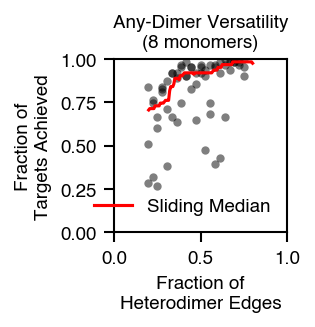

In [372]:
save = True

fig, ax = plt.subplots(figsize=(1.6,1.5))

rng = np.random.default_rng()

max_num_edges = num_combos_with_replacement(m,2)

edge_values = list(range(np.min(edges_by_param_set),np.max(edges_by_param_set)))
fraction_connectivities = [x/max_num_edges for x in edge_values]

all_x_vals = []
all_y_vals = []
# median_versatility_by_num_edges = []

for num_edges in edge_values:
    K_idx = np.where(edges_by_param_set==num_edges)[0]
    versatility_scores = versatility_anydimer_connectivity_df[versatility_anydimer_connectivity_df['KID'].isin(K_idx)]['goodenough']
    fraction_connectivity = num_edges/max_num_edges
    x_vals = [fraction_connectivity for x in range(len(versatility_scores))]
    ax.plot(x_vals,versatility_scores,marker='.',ls='',color='k',markersize=8,alpha=0.5,markeredgewidth=0)
    # median_versatility_by_num_edges.append(np.median(versatility_scores))
    all_x_vals.extend(x_vals)
    all_y_vals.extend(versatility_scores)

ax.set_xlabel('Fraction of\nHeterodimer Edges')
ax.set_ylabel('Fraction of\nTargets Achieved')
ax.set_title('Any-Dimer Versatility\n(8 monomers)')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_aspect(1)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# _ = ax.plot(fraction_connectivities,median_versatility_by_num_edges,linestyle='-',marker='',linewidth=1.5,color='r')

# Plot sliding window average
x_bin_centers,versatility_movingaverage = binned_average(np.array(all_x_vals), np.array(all_y_vals), \
                                            log_x=False, log_y=False,\
                                            extent=(0.2,0.8), x_bin_size=0.2, num_x_bins=100,min_points=5
                                            , summary_stat_function=np.median)
_ = ax.plot(x_bin_centers,versatility_movingaverage,linestyle='-',marker='',linewidth=1.5,color='r')

patches={}
patches[f'median'] = mlines.Line2D([], [], color='r', marker='', linestyle='-',linewidth=1.5,label='Median')

leg = ax.legend(loc='lower right',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    filename = f'FigS6A-2_versatility_anydimer_by_network_connectivity'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Supplementary Figure S6B-1: Versatility as projected number of functions possible (Single Dimer)

In [339]:
m_list = list(np.sort(np.unique(summary_df['m'])))
num_targets_by_m = [len(np.unique(summary_df[summary_df['m']==m]['targetID'])) for m in m_list] # Recall that not all unique functions were used as targets
num_Ks_by_m = [len(np.unique(summary_df[summary_df['m']==m]['KID'])) for m in m_list]

In [340]:
# Number of unique one-input functions by network size
num_unique_voxels_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_analysis_1D',f'num_unique_voxels_by_m.npy')),allow_pickle=True)

In [341]:
## Examine expressivity when maxing over output dimer

# This step assigns assigns an (m, KID, targetID) pair the maximum value of "goodenough" available over all its "dimerID" values
targets_achieved_singledimer_df = summary_df.groupby(['m','KID','dimerID','targetID'],as_index=False)['goodenough'].agg('max').reset_index(drop=True)

# Compute the number of functions each network was "goodenough" for.
targets_achieved_singledimer_df = targets_achieved_singledimer_df.groupby(['m','KID','dimerID'],as_index=False)['goodenough'].agg('sum')
targets_achieved_singledimer_df['fraction_goodenough'] = targets_achieved_singledimer_df['goodenough']
targets_achieved_singledimer_df['projected_unique_functions'] = targets_achieved_singledimer_df['goodenough']
for m_i, m in enumerate(m_list):
    indices = targets_achieved_singledimer_df[targets_achieved_singledimer_df['m']==m].index
    targets_achieved_singledimer_df.loc[indices,'fraction_goodenough'] = targets_achieved_singledimer_df.loc[indices,'fraction_goodenough']/num_targets_by_m[m_i]
    # Use fractions and full number of unique functions to predict number of unique functions
    targets_achieved_singledimer_df.loc[indices,'projected_unique_functions'] = targets_achieved_singledimer_df.loc[indices,'fraction_goodenough']*num_unique_voxels_by_m[m_i]

targets_achieved_singledimer_df.head()

,m,KID,dimerID,goodenough,fraction_goodenough,projected_unique_functions
0,2,0,0,2,0.1250,20.750
1,2,0,1,1,0.0625,10.375
2,2,0,2,2,0.1250,20.750
3,2,1,0,2,0.1250,20.750
4,2,1,1,1,0.0625,10.375


In [ ]:
save = False

# Make violin plot
fig, ax, parts = plot_violins(targets_achieved_singledimer_df, xname='m', yname='goodenough', marker='.',\
                             alpha=1, s=1,figsize=(3.1,2),plotpoints=True,subsample=150,widths=0.6,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Targets')
_ = ax.set_title('Number of Targets Achieved (Single Dimer)',fontsize=9)
roundup = 10
ymax = roundup*math.ceil(targets_achieved_singledimer_df['goodenough'].max()/roundup)
_ = ax.set_ylim([0,ymax])

_ = ax.set_yticks(np.arange(0,ymax+roundup,roundup))

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

if save:
    filename = f'Fig6Supp_targets_achieved_singledimer_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

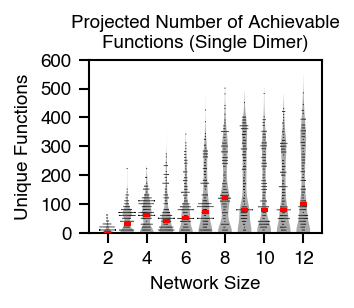

In [350]:
save = True

# Make violin plot
fig, ax, parts = plot_violins(targets_achieved_singledimer_df, xname='m', yname='projected_unique_functions', marker='.',\
                             alpha=1, s=0.5,figsize=(2,1.5),widths=0.7,plotpoints=True,subsample=200,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Unique Functions')
_ = ax.set_title('Projected Number of Achievable\nFunctions (Single Dimer)',fontsize=9)

roundup = 100
ymax = roundup*math.ceil(targets_achieved_singledimer_df['projected_unique_functions'].max()/roundup)
_ = ax.set_ylim([0,ymax])

_ = ax.set_yticks(np.arange(0,ymax+roundup,roundup))
_ = ax.set_xticks([2,4,6,8,10,12])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

if save:
    filename = f'FigS6B-1_projected_unique_functions_singledimer_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Supplementary Figure S6B-2: Versatility as projected number of functions possible (Any Dimer)

In [351]:
m_list = list(np.sort(np.unique(summary_df['m'])))
num_targets_by_m = [len(np.unique(summary_df[summary_df['m']==m]['targetID'])) for m in m_list] # Recall that not all unique functions were used as targets
num_Ks_by_m = [len(np.unique(summary_df[summary_df['m']==m]['KID'])) for m in m_list]

In [352]:
# Number of unique one-input functions by network size
num_unique_voxels_by_m = np.load(str(pathlib.Path(load_dir,'param_screen_analysis_1D',f'num_unique_voxels_by_m.npy')),allow_pickle=True)

In [353]:
## Examine expressivity when maxing over output dimer

# This step assigns assigns an (m, KID, targetID) pair the maximum value of "goodenough" available over all its "dimerID" values
targets_achieved_anydimer_df = summary_df.groupby(['m','KID','targetID'],as_index=False)['goodenough'].agg('max').reset_index(drop=True)

# Compute the number of functions each network was "goodenough" for.
targets_achieved_anydimer_df = targets_achieved_anydimer_df.groupby(['m','KID'],as_index=False)['goodenough'].agg('sum')
targets_achieved_anydimer_df['fraction_goodenough'] = targets_achieved_anydimer_df['goodenough']
targets_achieved_anydimer_df['projected_unique_functions'] = targets_achieved_anydimer_df['goodenough']
for m_i, m in enumerate(m_list):
    indices = targets_achieved_anydimer_df[targets_achieved_anydimer_df['m']==m].index
    targets_achieved_anydimer_df.loc[indices,'fraction_goodenough'] = targets_achieved_anydimer_df.loc[indices,'fraction_goodenough']/num_targets_by_m[m_i]
    # Use fractions and full number of unique functions to predict number of unique functions
    targets_achieved_anydimer_df.loc[indices,'projected_unique_functions'] = targets_achieved_anydimer_df.loc[indices,'fraction_goodenough']*num_unique_voxels_by_m[m_i]

targets_achieved_anydimer_df.head()

,m,KID,goodenough,fraction_goodenough,projected_unique_functions
0,2,0,5,0.3125,51.875
1,2,1,3,0.1875,31.125
2,2,2,2,0.1250,20.750
3,2,3,4,0.2500,41.500
4,2,4,0,0.0000,0.000


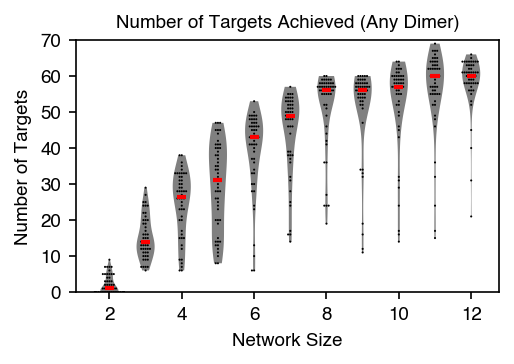

In [109]:
save = False

# Make violin plot
fig, ax, parts = plot_violins(targets_achieved_anydimer_df, xname='m', yname='goodenough', marker='.',\
                             alpha=1, s=1,figsize=(3.1,2),plotpoints=True,subsample=200,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of Targets')
_ = ax.set_title('Number of Targets Achieved (Any Dimer)',fontsize=9)
roundup = 10
ymax = roundup*math.ceil(targets_achieved_anydimer_df['goodenough'].max()/roundup)
_ = ax.set_ylim([0,ymax])

_ = ax.set_yticks(np.arange(0,ymax+roundup,roundup))

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

if save:
    filename = f'Fig6Supp_targets_achieved_anydimer_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

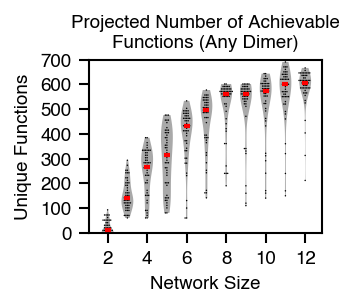

In [356]:
save = True

# Make violin plot
fig, ax, parts = plot_violins(targets_achieved_anydimer_df, xname='m', yname='projected_unique_functions', marker='.',\
                             alpha=1, s=0.7,figsize=(2,1.5),plotpoints=True,widths=0.6, subsample=200,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Unique Functions')
_ = ax.set_title('Projected Number of Achievable\nFunctions (Any Dimer)',fontsize=9)
roundup = 100
ymax = roundup*math.ceil(targets_achieved_anydimer_df['projected_unique_functions'].max()/roundup)
_ = ax.set_ylim([0,ymax])

# Customize spines
set_spine_linewidth(ax,1)

_ = ax.set_xticks([2,4,6,8,10,12])

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

_ = ax.set_yticks(np.arange(0,ymax+roundup,roundup))

if save:
    filename = f'FigS6B-2_projected_unique_functions_anydimer_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Supplementary Figure S6C-1: Fraction of Networks that Achieved Each Target (Single Dimer)

In [357]:
# This step assigns assigns an (m, KID, targetID) pair the maximum value of "goodenough" available over all its "dimerID" values

target_ease_singledimer_df = summary_df.groupby(['m','KID','dimerID','targetID'],as_index=False)['goodenough'].agg('max').reset_index(drop=True)

# For each target ID, sum goodenough
target_ease_singledimer_df = target_ease_singledimer_df.groupby(['m','targetID','dimerID'])['goodenough'].sum().reset_index()

# Convert raw number of K's to proportion of K's
for m_i, m in enumerate(m_list):
    indices = target_ease_singledimer_df[target_ease_singledimer_df['m']==m].index
    target_ease_singledimer_df.loc[indices,'goodenough'] = (target_ease_singledimer_df.loc[indices,'goodenough']/num_Ks_by_m[m_i])

target_ease_singledimer_df.head()

,m,targetID,dimerID,goodenough
0,2,14,0,0.28
1,2,14,1,0.00
2,2,14,2,0.00
3,2,16,0,0.14
4,2,16,1,0.00


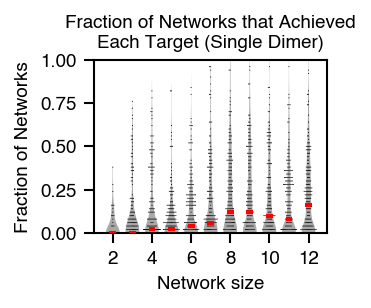

In [362]:
save = True

# Make violin plot
fig, ax, parts = plot_violins(target_ease_singledimer_df, xname='m', yname='goodenough', marker='.',\
                             alpha=1, s=0.5,figsize=(2,1.5),plotpoints=True,widths=0.7,subsample=200,color='darkgray')

ax.set_xlabel('Network size')
ax.set_ylabel('Fraction of Networks')
ax.set_title('Fraction of Networks Achieving\nEach Target (Single Dimer)',fontsize=9)
ax.set_ylim([0, 1])
_ = ax.set_xticks([2,4,6,8,10,12])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

if save:
    filename = f'FigS6C-1_target_ease_singledimer_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Supplementary Figure S6C-2: Fraction of Networks that Achieved Each Target (Any Dimer)

In [364]:
# This step assigns assigns an (m, KID, targetID) pair the maximum value of "goodenough" available over all its "dimerID" values

target_ease_anydimer_df = summary_df.groupby(['m','KID','targetID'],as_index=False)['goodenough'].agg('max').reset_index(drop=True)

# For each target ID, sum goodenough
target_ease_anydimer_df = target_ease_anydimer_df.groupby(['m','targetID'])['goodenough'].sum().reset_index()

# Convert raw number of K's to proportion of K's
for m_i, m in enumerate(m_list):
    indices = target_ease_anydimer_df[target_ease_anydimer_df['m']==m].index
    target_ease_anydimer_df.loc[indices,'goodenough'] = (target_ease_anydimer_df.loc[indices,'goodenough']/num_Ks_by_m[m_i])

target_ease_anydimer_df.head()

,m,targetID,goodenough
0,2,14,0.28
1,2,16,0.14
2,2,21,0.24
3,2,29,0.38
4,2,68,0.10


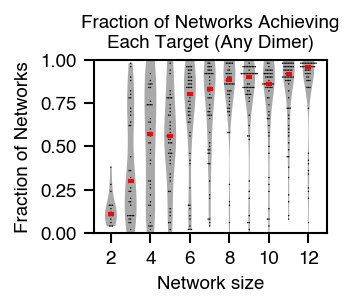

In [366]:
save = True

# Make violin plot
fig, ax, parts = plot_violins(target_ease_anydimer_df, xname='m', yname='goodenough', marker='.',\
                             alpha=1, s=0.7,figsize=(2,1.5),plotpoints=True,widths=0.6,subsample=200,color='darkgray')

ax.set_xlabel('Network size')
ax.set_ylabel('Fraction of Networks')
ax.set_title('Fraction of Networks Achieving\nEach Target (Any Dimer)',fontsize=9)
ax.set_ylim([0, 1])

_ = ax.set_xticks([2,4,6,8,10,12])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

if save:
    filename = f'FigS6C-2_target_ease_anydimer_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Supplementary Figure S6D: Changes in accessory expression needed for versatility

In [72]:
log_expression_diffs_bym_onedimer = list(np.load(pathlib.Path(load_dir,'optimization_trials_randomK_1D','versatility_expression_diffs','log_expression_diffs_bym_onedimer.npy'),allow_pickle=True))
log_expression_diffs_bym_onedimer_key = list(np.load(pathlib.Path(load_dir,'optimization_trials_randomK_1D','versatility_expression_diffs','log_expression_diffs_bym_onedimer_key.npy'),allow_pickle=True))
log_expression_diffs_bym_anydimer = list(np.load(pathlib.Path(load_dir,'optimization_trials_randomK_1D','versatility_expression_diffs','log_expression_diffs_bym_anydimer.npy'),allow_pickle=True))
log_expression_diffs_bym_anydimer_key = list(np.load(pathlib.Path(load_dir,'optimization_trials_randomK_1D','versatility_expression_diffs','log_expression_diffs_bym_anydimer_key.npy'),allow_pickle=True))
target_function_euclidean_dists_bym_onedimer = list(np.load(pathlib.Path(load_dir,'optimization_trials_randomK_1D','versatility_expression_diffs','target_function_euclidean_dists_bym_onedimer.npy'),allow_pickle=True))
target_function_euclidean_dists_bym_anydimer = list(np.load(pathlib.Path(load_dir,'optimization_trials_randomK_1D','versatility_expression_diffs','target_function_euclidean_dists_bym_anydimer.npy'),allow_pickle=True))

In [73]:
m = 8
statistic = 'max' # 'mean', 'median', 'max', 'euclidean'

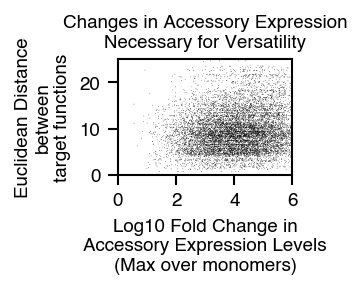

In [86]:
save = True

m_i = m_list.index(m)

# Create figure
fig, ax= plt.subplots(figsize=(1.5,1))

# Apply statistic
if statistic=='mean':
    expression_diff_statistics = np.mean(np.abs(log_expression_diffs_bym_anydimer[m_i]),axis=1)
elif statistic=='median':
    expression_diff_statistics = np.median(np.abs(log_expression_diffs_bym_anydimer[m_i]),axis=1)
elif statistic=='max':
    expression_diff_statistics = np.max(np.abs(log_expression_diffs_bym_anydimer[m_i]),axis=1)
elif statistic=='euclidean':
    expression_diff_statistics = np.sqrt(np.sum(log_expression_diffs_bym_anydimer[m_i]**2,axis=1))

# Randomly sample
rng = np.random.default_rng()
n_samples = 10000
if n_samples < expression_diff_statistics.shape[0]:
    random_subset = rng.choice(np.arange(expression_diff_statistics.shape[0]),size=n_samples,replace=False)
else:
    random_subset = np.arange(expression_diff_statistics.shape[0])
    n_samples = expression_diff_statistics.shape[0]

_ = ax.scatter(expression_diff_statistics[random_subset],target_function_euclidean_dists_bym_anydimer[m_i][random_subset],\
                s=0.1,color='k',alpha=1,edgecolors='none')

# Set axes limits
ax.set_xlim([0,6])
ax.set_ylim([0,25])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

_ = ax.set_ylabel('Euclidean Distance\nbetween\ntarget functions')
if statistic in ['mean','median','max']:
    xlabel_stat = statistic.capitalize()+' over monomers'
elif statistic=='euclidean':
    xlabel_stat = 'Euclidean Distance'
_ = ax.set_xlabel(f'Log10 Fold Change in\nAccessory Expression Levels\n({xlabel_stat})')
_ = ax.set_title(f'Changes in Accessory Expression\nNecessary for Versatility',fontsize=9)

# Save
if save:
    filename = f'FigS6D_accessory_exp_changes_vs_function_dist_anydimer_{m}M_{statistic}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Supplementary Figure S6E: 2-input, random K versatility at different Pearson thresholds

In [396]:
num_targets_2D = len(np.unique(summary_df_2D['targetID']))
num_Ks_2D = len(np.unique(summary_df_2D['KID']))

In [414]:
pearson_thresholds = [0.7,0.75, 0.8, 0.85, 0.9, 0.95]
for threshold_i, threshold in enumerate(pearson_thresholds):
    summary_df_2D[f'goodenough_pearson_{threshold_i}'] = summary_df_2D['Pearson_correlation_coefficient']>=threshold

In [415]:
## Examine expressivity when maxing over output dimer

# Compute the library efficiency of each (m, KID) pair by looking at the fraction of library it is "goodenough" for.
versatility_2input_df = pd.DataFrame(columns=['m','KID','pearson_threshold_i','goodenough_pearson'])
for threshold_i, threshold in enumerate(pearson_thresholds):
    versatility_2input_df_temp = summary_df_2D.groupby(['m','KID'],as_index=False)[f'goodenough_pearson_{threshold_i}'].agg('sum')
    versatility_2input_df_temp['pearson_threshold_i'] = threshold_i
    versatility_2input_df_temp.rename(columns={f'goodenough_pearson_{threshold_i}':'goodenough_pearson'},inplace=True)
    versatility_2input_df_temp[f'goodenough_pearson'] = versatility_2input_df_temp[f'goodenough_pearson']/num_targets_2D
    versatility_2input_df = pd.concat([versatility_2input_df,versatility_2input_df_temp],axis=0)

versatility_2input_df.head()

,m,KID,pearson_threshold_i,goodenough_pearson
0,20,0,0,0.7
1,20,1,0,1.0
2,20,2,0,0.9
3,20,3,0,0.9
4,20,4,0,1.0


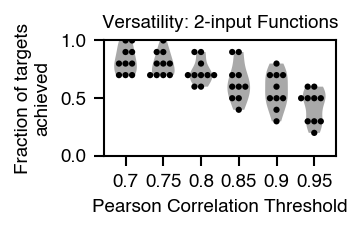

In [417]:
save = True

# Make violin plot
fig, ax, parts = plot_violins(versatility_2input_df, xname='pearson_threshold_i', yname='goodenough_pearson', marker='.',\
                             alpha=1, s=3,figsize=(2,1),plotpoints=True,subsample=False,\
                            color='darkgray',widths=0.6,showmedians=False)

# fig, ax, boxes = plot_boxes(versatility_2input_df, xname='m', yname='goodenough_pearson',\
#                                     figsize=(1,2),alpha=1, s=6, marker='.',\
#                                     linewidth=1,plotpoints=True,\
#                                     scatterwidth=0.4,boxwidth=0.4)
# boxes['medians'][0].set_linewidth(0)

_ = ax.set_xlabel('Pearson Correlation Threshold',fontsize=9)
_ = ax.set_ylabel('Fraction of targets\nachieved')
_ = ax.set_title('Versatility: 2-input Functions',fontsize=9)
_ = ax.set_ylim([0,1])

# xlabel_ids = [i for i,x in enumerate(pearson_thresholds) if i%2==0]
# xlabels = [x for i,x in enumerate(pearson_thresholds) if i%2==0]
# _ = ax.set_xticks(xlabel_ids,labels=xlabels)
_ = ax.set_xticks(range(len(pearson_thresholds)),labels=[str(round(x,2)) for x in pearson_thresholds])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

if save:
    filename = f'Fig6D_2D_versatility'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Supplementary Figure S6F: 2-input versatility for all tested random K's

In [30]:
num_targets_2D = len(np.unique(summary_df_2D['targetID']))
num_Ks_2D = len(np.unique(summary_df_2D['KID']))

We're going to order the rows top to bottom by number of successful functions:

In [46]:
pearson_threshold = 0.85

summary_df_2D['goodenough_pearson'] = summary_df_2D['Pearson_correlation_coefficient']>=pearson_threshold

## Examine expressivity when maxing over output dimer
# Compute the library efficiency of each (m, KID) pair by looking at the fraction of library it is "goodenough" for.
versatility_2input_df = summary_df_2D.groupby(['m','KID'],as_index=False)['goodenough_pearson'].agg('sum')

versatility_2input_df.loc[:,'goodenough_pearson'] = versatility_2input_df.loc[:,'goodenough_pearson']/num_targets_2D

versatility_2input_df = versatility_2input_df.sort_values('goodenough_pearson',ascending=False)

KIDs_to_plot = np.array(versatility_2input_df['KID'])

# Swap 3 and 4
KIDs_to_plot = np.array([4, 3, 2, 7, 1, 8, 9, 5, 6, 0])

In [47]:
# KIDs_to_plot = np.sort(np.unique(summary_df_2D['KID']))
# targets_to_plot = np.sort(np.unique(summary_df_2D['targetID']))
targets_to_plot = np.array(['ratio','NOR', 'OR','ANOTB','AND','NAND','XNOR','XOR','AeqB', 'DoubleBandpass']) # Re-order

In [48]:
targets_to_plot_labels =['Ratio','NOR', 'OR','NIMPLY','AND','NAND','XNOR','XOR','A=B', '2-input Bump']

In [49]:
t=12 # Number of input titration points, in each dimension
input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

KeyboardInterrupt: 

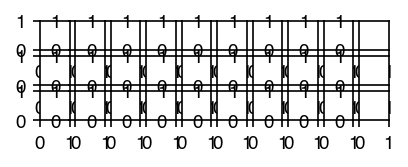

In [53]:
save = True

fig_height_inches = (len(KIDs_to_plot)+1)*0.3
fig_width_inches = len(targets_to_plot)*0.3

fig, axs = plt.subplots(nrows=len(KIDs_to_plot)+1,ncols=len(targets_to_plot),figsize=(fig_width_inches,fig_height_inches),sharex=True,sharey=True,\
                        # gridspec_kw={'left':0.075,'right':0.925,'hspace': 0.1, 'wspace': 0.1}
                        )

cmap = plt.get_cmap('viridis')

x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

# out_range = [10**input_lb,10**input_ub]
out_range = [10**input_lb,10**0]

for col, targetID in enumerate(targets_to_plot):
    # Plot target in first row
    row = 0
    target = 10**optimization_trials_randomK_2D_data[f'm-20_targetID-{targetID}_KID-1_dimerID-None']['f_target']
    # I normally use rasterized=True but for some reason the filesave fails in this case
    matrix = axs[row,col].pcolormesh(x_points,x_points,target.reshape((t,t)).T,\
                                        cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                        shading = 'nearest',rasterized=False)
            # shading='gouraud' or shading='nearest'
    for row, KID in enumerate(KIDs_to_plot):
        row +=1 # First row is for the target itself
        # Need to take transpose so that M1 appears on X-axis
        response = 10**optimization_trials_randomK_2D_data[f'm-20_targetID-{targetID}_KID-{KID}_dimerID-None']['f_fit']
        matrix = axs[row,col].pcolormesh(x_points,x_points,response.reshape((t,t)).T,\
                                        cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                        shading = 'nearest',rasterized=False)
            # shading='gouraud' or shading='nearest'

for col in range(len(targets_to_plot)):
    for row in range(len(KIDs_to_plot)+1):
        axs[row,col].xaxis.set_ticks_position("bottom")
        axs[row,col].set_xscale('log')
        axs[row,col].set_yscale('log')
        # axs[row,col].set_xlabel(f'Input M1')
        # axs[row,col].set_ylabel(f'Input M2')
        axs[row,col].set_aspect(1) # Ensure that plot area is a perfect square
        axs[row,col].set_xlim([10**input_lb,10**input_ub])
        axs[row,col].set_ylim([10**input_lb,10**input_ub])
        # Customize spines
        set_spine_linewidth(axs[row,col],1)

        # Set ticks
        axs[row,col].tick_params(axis='both', which='both', bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False)  
        # if col==0:
        #     set_simple_log_ticks(axs[row,col],which='y',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)
        # else:
        #     axs[row,col].set_yticklabels([])
        # if row==len(KIDs_to_plot):
        #     set_simple_log_ticks(axs[row,col],which='x',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)
        # else:
        #     axs[row,col].set_xticklabels([])
        # Customize the major ticks
        # axs[row,col].tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks
        # Customize the minor ticks
        # axs[row,col].tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks
        # axs[row,col].xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
        # axs[row,col].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

for row, KID in enumerate(['Target'] + list(KIDs_to_plot)):  # Include 'Target' for the first row
    axs[row, 0].text(-0.2, 0.5, str(KID), va='center', ha='right', transform=axs[row, 0].transAxes, fontsize=9)

for col, targetID in enumerate(targets_to_plot):
    axs[-1, col].text(0.5, -0.1, f'{targets_to_plot_labels[col]}', va='top', ha='right', transform=axs[-1, col].transAxes, fontsize=9,rotation=45)

# _ = fig.supxlabel('Input M1',fontsize=9,y=0.015)
# _ = fig.supylabel('Input M2',fontsize=9)

fig.set_dpi(300)

if save:
    filename = f'FigS6F_all_randomK_2D_fits'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished: Are functions with more local extrema more difficult to fit? (Single Dimer)

In [90]:
#To annotate target complexity (local extrema), run this cell.

def get_critical_points_forray(curves,extrema_threshold=0.2):
    '''
    Takes a small set of responses, and returns the local minima, maxima, and inflection points

    Parameters
    ----------
    curves : Array-like, shape (n_responses, t)
        Array of responses to analyze
    extrema_threshold : float, default 0.2
        "Prominence" for np.signal.find_peaks to find local minima and maxima.
        "...vertical distance between the peak and its lowest contour line." 
    
    Returns
    -------
    local_mins : list of arrays, len n_responses
        List of arrays of local minima (indices in the input domain) for each response
    local_maxs : list of arrays, len n_responses
        List of arrays of local maxima (indices in the input domain) for each response
    pos_inflection_points : list of arrays, len n_responses
        List of arrays of positive inflection points (indices in the input domain) for each response
    neg_inflection_points : list of arrays, len n_responses
        List of arrays of negative inflection points (indices in the input domain) for each response
    '''
    num_curves = curves.shape[0]
    t = curves.shape[1]
    curves = curves.copy()
    # Calculate local extrema with scipy.signal.find_peaks
    local_mins = [scipy.signal.find_peaks(-curves[x],prominence =extrema_threshold)[0] for x in range(num_curves)]
    local_maxs = [scipy.signal.find_peaks(curves[x],prominence =extrema_threshold)[0] for x in range(num_curves)]
    # Calculate discrete second derivative with np.diff
    d2x_dt2 = np.concatenate((np.zeros((num_curves,2)),np.diff(curves,n=2,axis=1)),axis=1)

    return (local_mins, local_maxs)

    # # Find inflection points by looking for changes-of-sign of the second derivative
    # neg_inflection_points = [np.where(np.diff(np.sign(d2x_dt2[x]),n=1)==-2)[0] for x in range(num_curves)]
    # pos_inflection_points = [np.where(np.diff(np.sign(d2x_dt2[x]),n=1)==2)[0] for x in range(num_curves)]
    # return (local_mins, local_maxs, pos_inflection_points, neg_inflection_points)

m_list = list(np.sort(np.unique(summary_df['m'])))
local_mins_by_target_by_m = {}
local_maxs_by_target_by_m = {}
local_extrema_by_target_by_m = {}

for m in m_list:
  voxel_averages = np.load(str(pathlib.Path(load_dir,'optimization_trials_randomK_1D',\
                                            'target_functions',f'{m}M_voxel_averages.npy')),allow_pickle=True)
  targets_used = np.sort(np.unique(summary_df[summary_df['m']==m]['targetID'])).astype(np.int64)
  local_mins, local_maxs = \
      get_critical_points_forray(voxel_averages[targets_used,:],extrema_threshold=0.2)
  local_mins_by_target_by_m[m] = [int(len(x)) for x in local_mins]
  local_maxs_by_target_by_m[m] = [int(len(x)) for x in local_maxs]
  local_extrema_by_target_by_m[m] = [int(len(x)+len(y)) for x,y in zip(local_mins,local_maxs)]

summary_df = summary_df.sort_values(by=['m','targetID','KID','dimerID']).reset_index(drop=True)

for m in m_list:
    voxel_averages = np.load(str(pathlib.Path(load_dir,'optimization_trials_randomK_1D',\
                                            'target_functions',f'{m}M_voxel_averages.npy')),allow_pickle=True)
    for target_i, targetID in enumerate(np.sort(np.unique(summary_df[summary_df['m']==m]['targetID']))):
        indices = summary_df[(summary_df['m']==m)&(summary_df['targetID']==targetID)].index
        summary_df.loc[indices,'local_mins'] = local_mins_by_target_by_m[m][target_i]
        summary_df.loc[indices,'local_maxs'] = local_maxs_by_target_by_m[m][target_i]
        summary_df.loc[indices,'local_extrema'] = local_extrema_by_target_by_m[m][target_i]
        if local_extrema_by_target_by_m[m][target_i]==0:
            voxel_average = voxel_averages[targetID,:]
            if voxel_average[-1]>voxel_average[0]:
              summary_df.loc[indices,'monotonic_type'] = 'increasing'
            elif voxel_average[-1]<voxel_average[0]:
              summary_df.loc[indices,'monotonic_type'] = 'decreasing'
            else:
              summary_df.loc[indices,'monotonic_type'] = 'neither'
        else:
            summary_df.loc[indices,'monotonic_type'] = 'neither'

summary_df['local_mins'] = summary_df['local_mins'].astype(int)
summary_df['local_maxs'] = summary_df['local_maxs'].astype(int)
summary_df['local_extrema'] = summary_df['local_extrema'].astype(int)

In [105]:
# This step assigns assigns an (m, KID, targetID) pair the maximum value of "goodenough" available over all its "dimerID" values
target_ease_singledimer_byextrema = summary_df.groupby(['m','KID','targetID','local_extrema'],as_index=False)['goodenough'].agg('max').reset_index(drop=True)

# For each target ID, sum goodenough
target_ease_singledimer_byextrema = target_ease_singledimer_byextrema.groupby(['m','targetID','local_extrema'])['goodenough'].sum().reset_index()

# Convert raw number of K's to proportion of K's
for m_i, m in enumerate(m_list):
    indices = target_ease_singledimer_byextrema[target_ease_singledimer_byextrema['m']==m].index
    target_ease_singledimer_byextrema.loc[indices,'goodenough'] = (target_ease_singledimer_byextrema.loc[indices,'goodenough']/num_Ks_by_m[m_i])

target_ease_singledimer_byextrema.head()

,m,targetID,local_extrema,goodenough
0,2,14,0,0.28
1,2,16,0,0.14
2,2,21,0,0.24
3,2,29,0,0.38
4,2,68,0,0.10


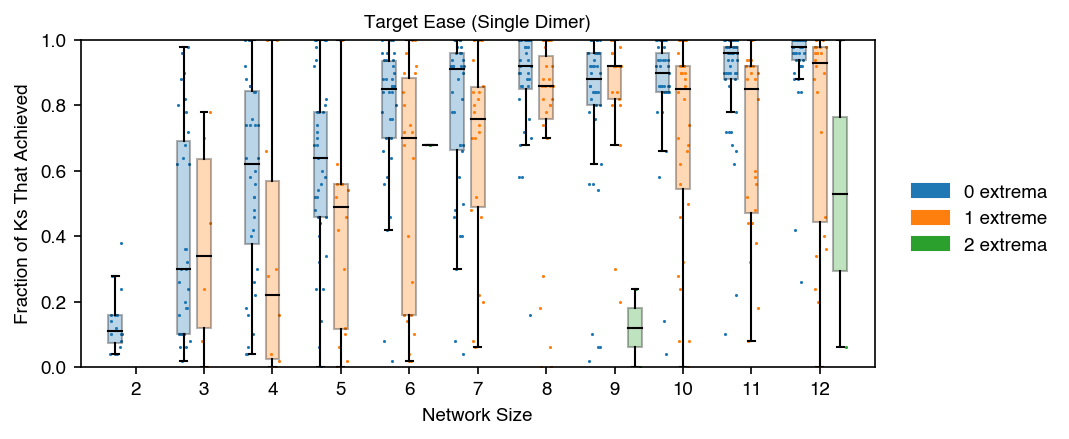

In [107]:
save = True

# Make box plots grouped by type of dimer

order = list(np.sort(np.unique(target_ease_singledimer_byextrema['local_extrema'])))
cmap = plt.get_cmap('tab10')
fig, ax = plot_boxes_grouped(df=target_ease_singledimer_byextrema, xname='m', yname='goodenough', category='local_extrema', \
                             category_order=order,cmap=cmap,s=3,marker='.',alpha=1,figsize=(6,3))

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction of Ks That Achieved')
_ = ax.set_title('Target Ease (Single Dimer)',fontsize=9)

_ = ax.set_xticks(list(range(2,13)))
_ = ax.set_xticklabels(list(range(2,13)))
_ = ax.set_ylim([0,1])

patches={}
labels = [f'{num_extrema} extrema' if num_extrema!=1 else '1 extreme' for num_extrema in order]
for i,num_extrema in enumerate(order):
    patches[num_extrema] = mpatches.Patch(color=cmap(i),label=labels[i])

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    plt.tight_layout()
    filename = f'Fig6Supp_target_ease_singledimer_by_extrema'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished: Are functions with more local extrema more difficult to fit? (Any Dimer)

In [91]:
#To annotate target complexity (local extrema), run this cell.

def get_critical_points_forray(curves,extrema_threshold=0.2):
    '''
    Takes a small set of responses, and returns the local minima, maxima, and inflection points

    Parameters
    ----------
    curves : Array-like, shape (n_responses, t)
        Array of responses to analyze
    extrema_threshold : float, default 0.2
        "Prominence" for np.signal.find_peaks to find local minima and maxima.
        "...vertical distance between the peak and its lowest contour line." 
    
    Returns
    -------
    local_mins : list of arrays, len n_responses
        List of arrays of local minima (indices in the input domain) for each response
    local_maxs : list of arrays, len n_responses
        List of arrays of local maxima (indices in the input domain) for each response
    pos_inflection_points : list of arrays, len n_responses
        List of arrays of positive inflection points (indices in the input domain) for each response
    neg_inflection_points : list of arrays, len n_responses
        List of arrays of negative inflection points (indices in the input domain) for each response
    '''
    num_curves = curves.shape[0]
    t = curves.shape[1]
    curves = curves.copy()
    # Calculate local extrema with scipy.signal.find_peaks
    local_mins = [scipy.signal.find_peaks(-curves[x],prominence =extrema_threshold)[0] for x in range(num_curves)]
    local_maxs = [scipy.signal.find_peaks(curves[x],prominence =extrema_threshold)[0] for x in range(num_curves)]
    # Calculate discrete second derivative with np.diff
    d2x_dt2 = np.concatenate((np.zeros((num_curves,2)),np.diff(curves,n=2,axis=1)),axis=1)

    return (local_mins, local_maxs)

    # # Find inflection points by looking for changes-of-sign of the second derivative
    # neg_inflection_points = [np.where(np.diff(np.sign(d2x_dt2[x]),n=1)==-2)[0] for x in range(num_curves)]
    # pos_inflection_points = [np.where(np.diff(np.sign(d2x_dt2[x]),n=1)==2)[0] for x in range(num_curves)]
    # return (local_mins, local_maxs, pos_inflection_points, neg_inflection_points)

m_list = list(np.sort(np.unique(summary_df['m'])))
local_mins_by_target_by_m = {}
local_maxs_by_target_by_m = {}
local_extrema_by_target_by_m = {}

for m in m_list:
  voxel_averages = np.load(str(pathlib.Path(load_dir,'optimization_trials_randomK_1D',\
                                            'target_functions',f'{m}M_voxel_averages.npy')),allow_pickle=True)
  targets_used = np.sort(np.unique(summary_df[summary_df['m']==m]['targetID'])).astype(np.int64)
  local_mins, local_maxs = \
      get_critical_points_forray(voxel_averages[targets_used,:],extrema_threshold=0.2)
  local_mins_by_target_by_m[m] = [int(len(x)) for x in local_mins]
  local_maxs_by_target_by_m[m] = [int(len(x)) for x in local_maxs]
  local_extrema_by_target_by_m[m] = [int(len(x)+len(y)) for x,y in zip(local_mins,local_maxs)]

summary_df = summary_df.sort_values(by=['m','targetID','KID','dimerID']).reset_index(drop=True)

for m in m_list:
    voxel_averages = np.load(str(pathlib.Path(load_dir,'optimization_trials_randomK_1D',\
                                            'target_functions',f'{m}M_voxel_averages.npy')),allow_pickle=True)
    for target_i, targetID in enumerate(np.sort(np.unique(summary_df[summary_df['m']==m]['targetID']))):
        indices = summary_df[(summary_df['m']==m)&(summary_df['targetID']==targetID)].index
        summary_df.loc[indices,'local_mins'] = local_mins_by_target_by_m[m][target_i]
        summary_df.loc[indices,'local_maxs'] = local_maxs_by_target_by_m[m][target_i]
        summary_df.loc[indices,'local_extrema'] = local_extrema_by_target_by_m[m][target_i]
        if local_extrema_by_target_by_m[m][target_i]==0:
            voxel_average = voxel_averages[targetID,:]
            if voxel_average[-1]>voxel_average[0]:
              summary_df.loc[indices,'monotonic_type'] = 'increasing'
            elif voxel_average[-1]<voxel_average[0]:
              summary_df.loc[indices,'monotonic_type'] = 'decreasing'
            else:
              summary_df.loc[indices,'monotonic_type'] = 'neither'
        else:
            summary_df.loc[indices,'monotonic_type'] = 'neither'

summary_df['local_mins'] = summary_df['local_mins'].astype(int)
summary_df['local_maxs'] = summary_df['local_maxs'].astype(int)
summary_df['local_extrema'] = summary_df['local_extrema'].astype(int)

In [92]:
# This step assigns assigns an (m, KID, targetID) pair the maximum value of "goodenough" available over all its "dimerID" values
target_ease_anydimer_byextrema = summary_df.groupby(['m','KID','targetID','local_extrema'],as_index=False)['goodenough'].agg('max').reset_index(drop=True)

# For each target ID, sum goodenough
target_ease_anydimer_byextrema = target_ease_anydimer_byextrema.groupby(['m','targetID','local_extrema'])['goodenough'].sum().reset_index()

# Convert raw number of K's to proportion of K's
for m_i, m in enumerate(m_list):
    indices = target_ease_anydimer_byextrema[target_ease_anydimer_byextrema['m']==m].index
    target_ease_anydimer_byextrema.loc[indices,'goodenough'] = (target_ease_anydimer_byextrema.loc[indices,'goodenough']/num_Ks_by_m[m_i])

target_ease_anydimer_byextrema.head()

,m,targetID,local_extrema,goodenough
0,2,14,0,0.28
1,2,16,0,0.14
2,2,21,0,0.24
3,2,29,0,0.38
4,2,68,0,0.10


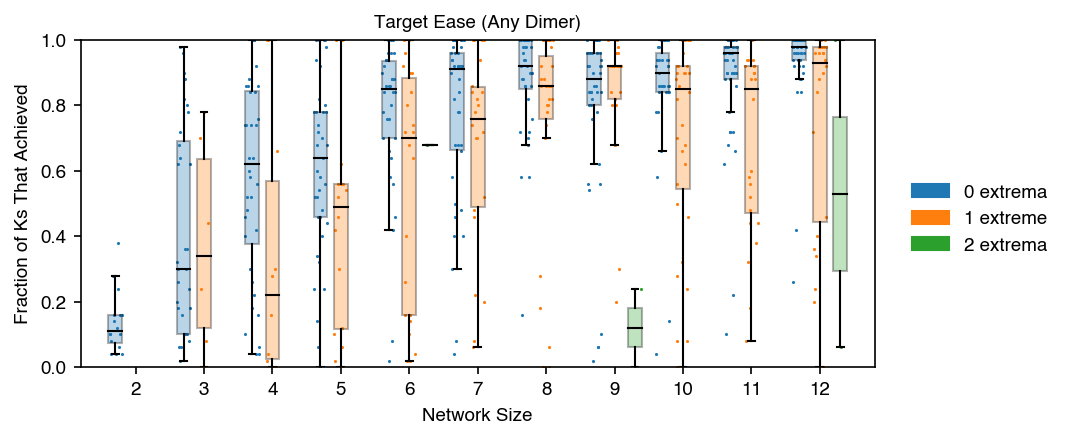

In [108]:
save = True

# Make box plots grouped by type of dimer

order = list(np.sort(np.unique(target_ease_anydimer_byextrema['local_extrema'])))
cmap = plt.get_cmap('tab10')
fig, ax = plot_boxes_grouped(df=target_ease_anydimer_byextrema, xname='m', yname='goodenough', category='local_extrema', \
                             category_order=order,cmap=cmap,s=3,marker='.',alpha=1,figsize=(6,3))

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction of Ks That Achieved')
_ = ax.set_title('Target Ease (Any Dimer)',fontsize=9)

_ = ax.set_xticks(list(range(2,13)))
_ = ax.set_xticklabels(list(range(2,13)))
_ = ax.set_ylim([0,1])

patches={}
labels = [f'{num_extrema} extrema' if num_extrema!=1 else '1 extreme' for num_extrema in order]
for i,num_extrema in enumerate(order):
    patches[num_extrema] = mpatches.Patch(color=cmap(i),label=labels[i])

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    plt.tight_layout()
    filename = f'Fig6Supp_target_ease_anydimer_by_extrema'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished:  Single-Dimer Versatility by Dimer Type

### Load data

In [109]:
#To annotate dimer types (e.g. input-input homodimer, acc-acc heterodimer etc.)
#run this cell. 

with open(pathlib.Path(load_dir,'optimization_trials_randomK_1D','name_dict.pkl'), 'rb') as f:
  name_dict = pickle.load(f)

#Create df annotating dimerID as input-input homodimer, input-accessory heterodimer,
#accessory-accessory homodimer and accessory-accessory heterodimer
annotation_dfs = []
for m in name_dict['K_names'].keys():
  dimer_labels = ['input_input_homodimer'] +  ['input_acc_heterodimer'] * (m-1)
  for i in range(m-1, 0, -1):
    dimer_labels.append('acc_acc_homodimer')
    dimer_labels.extend(['acc_acc_heterodimer'] * (i-1))
  tmp_df = pd.DataFrame({'m': [m]*len(dimer_labels), 
                         'dimerID': np.arange(len(dimer_labels)),
                         'K_name': name_dict['K_names'][m],
                         'dimer_type': dimer_labels})
  annotation_dfs.append(tmp_df)

dimer_annotations = pd.concat(annotation_dfs)

summary_df = summary_df.merge(dimer_annotations, how='left',
                              on = ['m', 'dimerID'])

# Split dimer_type into two classes: has_input (True/False) and dimer_combination
summary_df['has_input'] = False
summary_df.loc[summary_df.dimer_type.str.contains('input'), "has_input"] = True

summary_df['dimer_combination'] = 'heterodimer'
summary_df.loc[summary_df.dimer_type.str.contains('homo'), "dimer_combination"] = 'homodimer'

### Analyze and Plot

In [122]:
# This step assigns assigns an (m, KID, targetID) pair the maximum value of "goodenough" available over all its "dimerID" values
versatility_singledimer_dimertype_df = summary_df.groupby(['m','KID','targetID','dimer_type'],as_index=False)['goodenough'].agg('max').reset_index(drop=True)

# Compute the library efficiency of each (m, KID) pair by looking at the fraction of library it is "goodenough" for.
versatility_singledimer_dimertype_df = versatility_singledimer_dimertype_df.groupby(['m','KID','dimer_type'],as_index=False)['goodenough'].agg('sum')
for m_i, m in enumerate(m_list):
    indices = versatility_singledimer_dimertype_df[versatility_singledimer_dimertype_df['m']==m].index
    versatility_singledimer_dimertype_df.loc[indices,'goodenough'] = versatility_singledimer_dimertype_df.loc[indices,'goodenough']/num_targets_by_m[m_i]

versatility_singledimer_dimertype_df.head()

,m,KID,dimer_type,goodenough
0,2,0,acc_acc_homodimer,0.1250
1,2,0,input_acc_heterodimer,0.0625
2,2,0,input_input_homodimer,0.1250
3,2,1,acc_acc_homodimer,0.0000
4,2,1,input_acc_heterodimer,0.0625


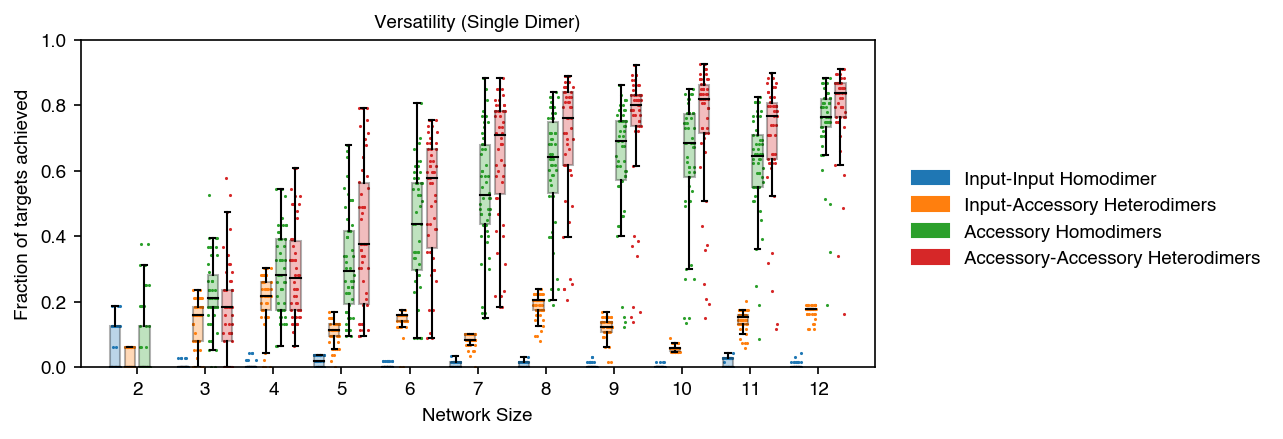

In [127]:
save = True

# Make violin plots grouped by type of dimer
# order = input homo, input-acc hetero, acc homo, acc-acc hetero
order = ['input_input_homodimer', 'input_acc_heterodimer', 'acc_acc_homodimer', 'acc_acc_heterodimer']
cmap = plt.get_cmap('tab10')
fig, ax = plot_boxes_grouped(df=versatility_singledimer_dimertype_df, xname='m', yname='goodenough', category='dimer_type', \
                             category_order=order,cmap=cmap,s=3,marker='.',alpha=1,figsize=(6,3),linewidth=1)

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Fraction of targets achieved')
_ = ax.set_title('Versatility (Single Dimer)')
_ = ax.set_xticks(list(range(2,13)))
_ = ax.set_xticklabels(list(range(2,13)))
_ = ax.set_ylim([0,1])

patches={}
patches['input_input_homodimer'] = mpatches.Patch(color=cmap(0),label=f'Input-Input Homodimer')
patches['input_acc_heterodimers'] = mpatches.Patch(color=cmap(1),label=f'Input-Accessory Heterodimers')
patches['acc_acc_homodimers'] = mpatches.Patch(color=cmap(2),label=f'Accessory Homodimers')
patches['acc_acc_heterodimers'] = mpatches.Patch(color=cmap(3),label=f'Accessory-Accessory Heterodimers')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    plt.tight_layout()
    filename = f'Fig6Supp_versatility_singledimer_by_dimer_type'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished:  Can a single network have robust and versatile dimers?

In [128]:
versatility_range_withinnetwork = versatility_singledimer_df.groupby(by=['m','KID'])['goodenough'].agg(lambda x: np.max(x)-np.min(x)).reset_index()
versatility_std_withinnetwork = versatility_singledimer_df.groupby(by=['m','KID'])['goodenough'].agg(lambda x: np.std(x)).reset_index()
versatility_range_withinnetwork.head()
versatility_std_withinnetwork.head()

,m,KID,goodenough
0,2,0,0.029463
1,2,1,0.051031
2,2,2,0.058926
3,2,3,0.029463
4,2,4,0.000000


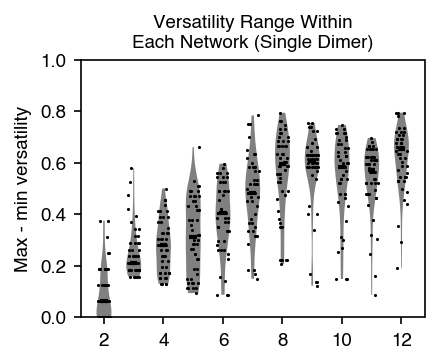

In [133]:
save = True

# Make violin plot
fig, ax, parts = plot_violins(versatility_range_withinnetwork, xname='m', yname='goodenough',\
                                     figsize=(3,2.5),s=3,alpha=1,plotpoints=True)

_ = ax.set_ylabel('Max - min versatility')
_ = ax.set_title('Versatility Range Within\nEach Network (Single Dimer)')
_ = ax.set_ylim([0,1])

if save:
    plt.tight_layout()
    filename = f'Fig6Supp_versatility_range_singledimer_withinnetwork'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

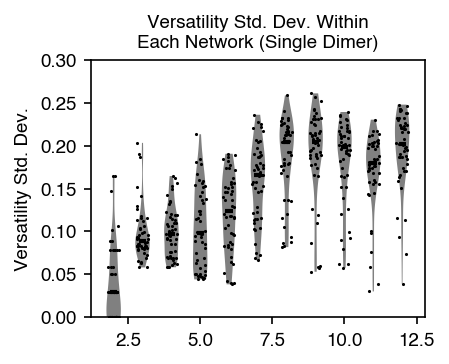

In [135]:
save = True

# Make violin plot
fig, ax, parts = plot_violins(versatility_std_withinnetwork, xname='m', yname='goodenough',\
                                     figsize=(3,2.5),s=3,alpha=1,plotpoints=True)

_ = ax.set_ylabel('Versatility Std. Dev.')
_ = ax.set_title('Versatility Std. Dev. Within\nEach Network (Single Dimer)')
_ = ax.set_ylim([0,0.3])

if save:
    plt.tight_layout()
    filename = f'Fig6Supp_versatility_stdev_singledimer_withinnetwork'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished:  Impressive example of 1D versatility

In [10]:
m_list = list(np.sort(np.unique(summary_df['m'])))
num_targets_by_m = [len(np.unique(summary_df[summary_df['m']==m]['targetID'])) for m in m_list] # Recall that not all unique functions were used as targets
num_Ks_by_m = [len(np.unique(summary_df[summary_df['m']==m]['KID'])) for m in m_list]

In [11]:
# Examine fits by treating all (K, dimer) pairs as independent systems

# for each m, what fraction of expressible targets can be achieved using a random K, a random output dimer, and a tuned a
versatility_singledimer_df = summary_df.groupby(['m','KID', 'dimerID'],as_index=False)['goodenough'].agg('sum')
for m_i, m in enumerate(m_list):
    indices = versatility_singledimer_df[versatility_singledimer_df['m']==m].index
    versatility_singledimer_df.loc[indices,'goodenough'] = versatility_singledimer_df.loc[indices,'goodenough']/num_targets_by_m[m_i]

versatility_singledimer_df = versatility_singledimer_df.sort_values(by='goodenough',ascending=False)

versatility_singledimer_df.head(20)

,m,KID,dimerID,goodenough
17990,12,47,74,0.794118
17538,12,42,12,0.794118
16404,12,27,48,0.794118
4883,8,20,13,0.793651
3149,7,14,7,0.783333
16018,12,22,52,0.779412
5132,8,27,10,0.761905
4893,8,20,23,0.761905
5313,8,32,11,0.761905
6794,9,18,34,0.753846


### Load in data

In [19]:
with open(pathlib.Path(load_dir,'optimization_trials_randomK_1D',\
                                      'a_opt.pkl'), 'rb') as f:
  optimized_expression_levels = pickle.load(f)

with open(pathlib.Path(load_dir,'optimization_trials_randomK_1D',\
                                      'K_random.pkl'), 'rb') as f:
  K_random = pickle.load(f)

### Define simulation functions

In [13]:
def run_eqtk(N, C0, params, acc_monomer_ind):
    """
    Run eqtk.solve given the input stoichiometry matrix, initial concentrations, and parameters.

    See eqtk.solve documentation for more details on the syntax.
    (https://eqtk.github.io/user_guide/generated/highlevel/eqtk.solve.html)

    Parameters
    ----------
    N : Array-like, shape (num_rxns, num_species)
        Input stoichiometry matrix
    C0 : Array-like, shape (num_simulation_points, num_species)
        Initial concentrations of all species for each simulation point.
        Accessory monomer levels will be set based on params.
    params : List-like, len num_combos_with_replacement(m,2) + (m-1)
        Parameters including Kij values and accessory monomer levels
    acc_monomer_ind : int  
        Index of accessory monomers in species list
    
    Returns
    -------
    C: Array-like
        Equilibrium concentrations of all species
    """
    num_rxns = N.shape[0]
    # Extract Kij values
    K = params[:num_rxns]
    # Set accessory monomer levels
    C0[:,acc_monomer_ind] = params[num_rxns:]

    return eqtk.solve(c0=C0, N=N, K=K)

In [14]:
def simulate_networks(m, num_inputs, param_sets, t = 12, input_lb = -3, input_ub = 3):
    """
    Run simulations for dimer networks, over a titration of concentrations for each input monomer. 
    When >1 input monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, 
    while the second is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species in the network.
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. Log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species.Llog10 scale
    param_sets : Array-like, shape (num_sets, num_parameters)
        Parameter sets for simulating multiple dimerization networks.  
    Returns
    -------
    C0 : Array-like, shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : Array-like, shape (t, number of species, num_sets) 
        Equlibrium concentration of all species
        for all parameter sets and each input titration point.
        
    """
    # Create stoichiometry matrix 
    num_sets = param_sets.shape[0]
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]

    # Create initial concentration array
    M0_min = [input_lb]*num_inputs + [0] * (m-num_inputs) # Species concentrations at min of inputs
    M0_max = [input_ub]*num_inputs + [0] * (m-num_inputs) # Species concentrations at max of inputs
    num_conc = [t]*num_inputs + [1] * (m-num_inputs) # Number of concentrations to titrate for each species
    C0 = make_C0_grid(m, M0_min=M0_min, M0_max=M0_max, num_conc=num_conc) 
        
    acc_monomer_ind = np.arange(num_inputs,m) # Indices of accessory monomers
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    # For each parameter set, run eqtk.solve
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, acc_monomer_ind)
    return C0,S_all  

### Now actually make plots

#### Screen for candidates


In [23]:
num_inputs = 1
m = 10
KID = 47
dimerID = 53

targets_achieved = summary_df[(summary_df['m']==m)&\
                                (summary_df['KID']==KID)&\
                                (summary_df['dimerID']==dimerID)&\
                                (summary_df['goodenough'])]['targetID'].sort_values().unique().tolist()

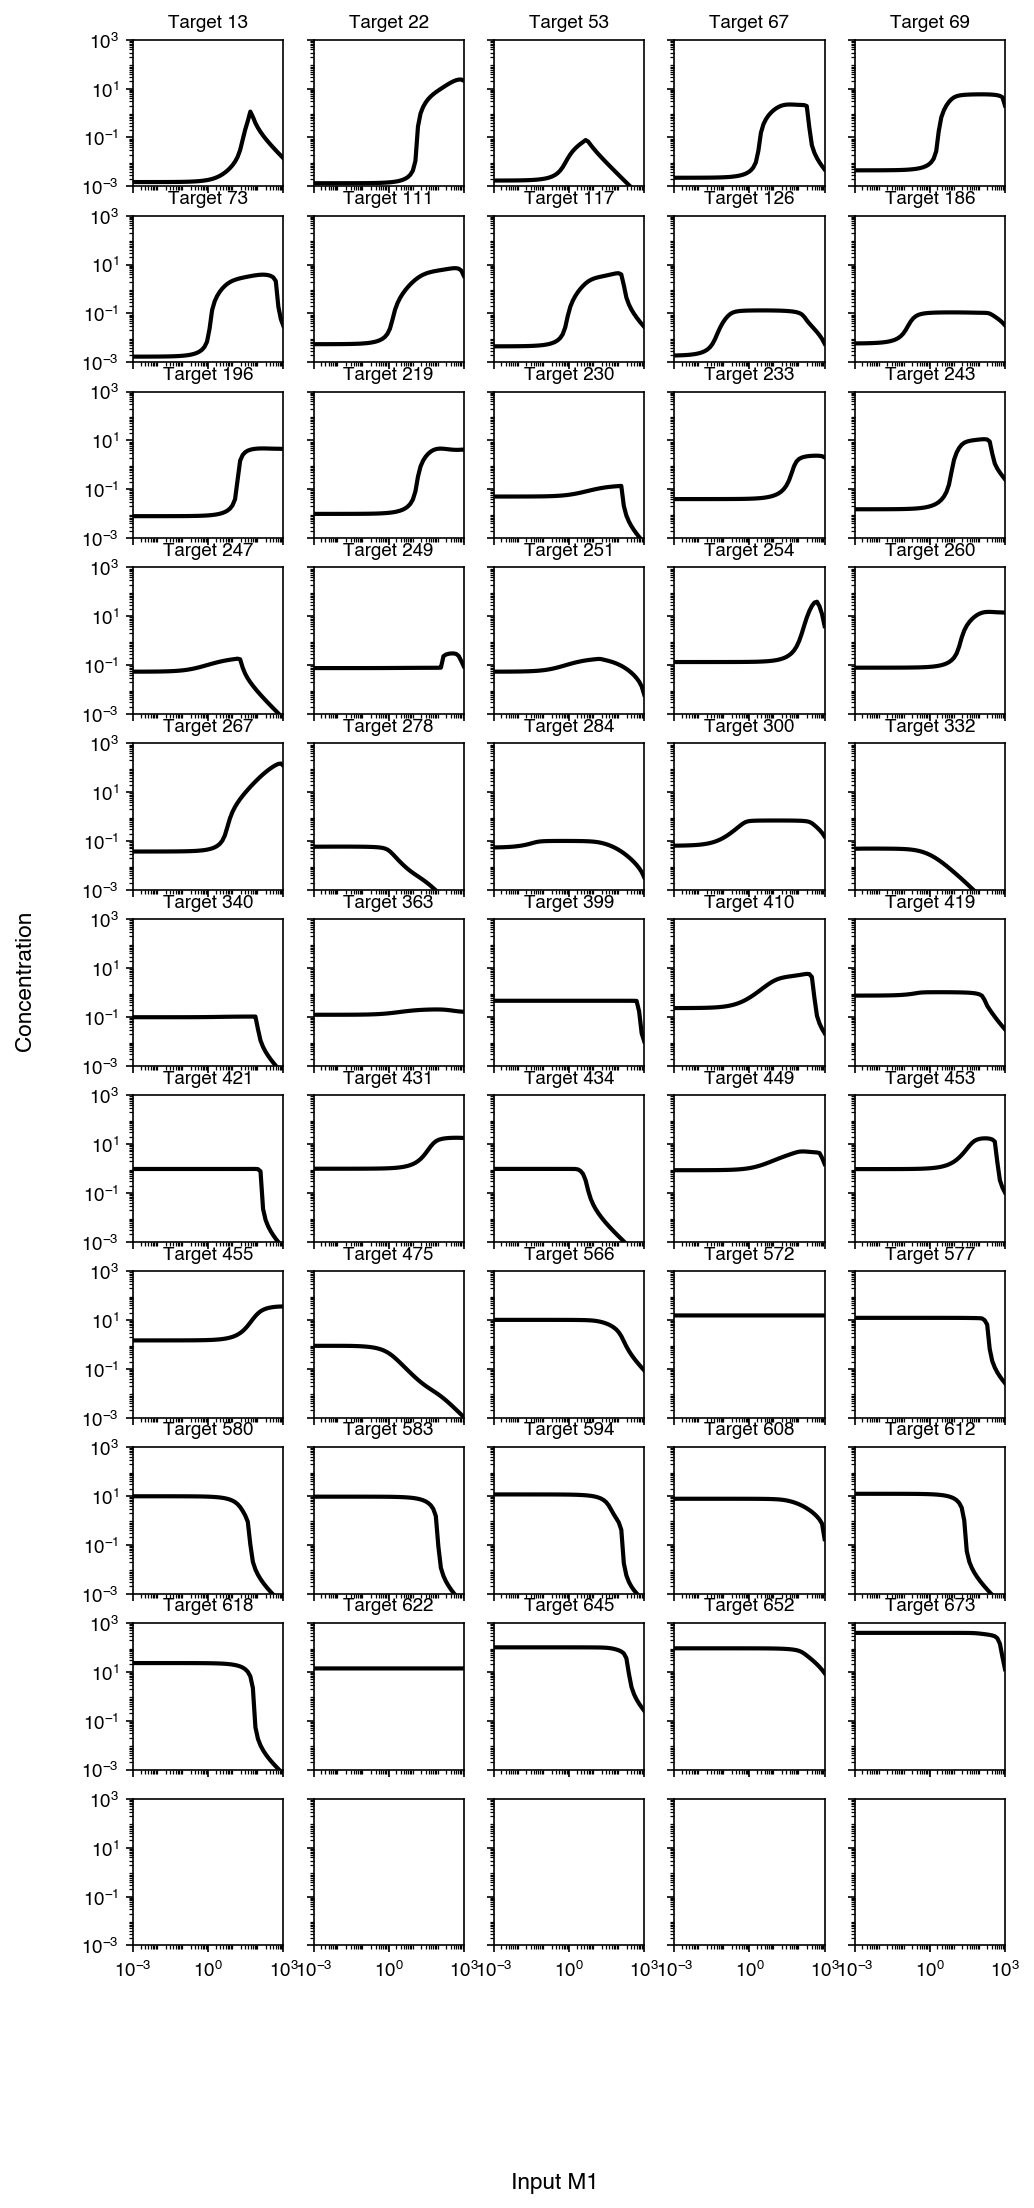

In [24]:
ncols = 5
nrows = len(targets_achieved)//ncols + 1

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(ncols*1.5,nrows*1.5),sharex=True,sharey=True)
K = K_random[m][KID]
for i,targetID in enumerate(targets_achieved):
    row = i//ncols
    col = i%ncols
    ax = axes[row,col]
    t=60 # Number of input titration points
    input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
    input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale
    
    A = 10**optimized_expression_levels[m][KID,dimerID,targetID,:]
    if np.any(np.isnan(A)):
        print("A values not found")
        break

    C0,S_all  = simulate_networks(m, num_inputs=num_inputs,param_sets=np.expand_dims(np.hstack((K,A)),axis=0), t = t, input_lb = input_lb, input_ub = input_ub)

    out_range = [1e-3,1e3] # Output concentration range

    min_affinity = 1e-5 # Will not plot dimers below this affinity (assumed not to dimerize)

    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

    ax.plot(x_points,S_all[:,m+dimerID,0],marker=None,linestyle='-',color='k',\
                        alpha=1,lw=2)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([10**input_lb,10**input_ub])
    ax.set_ylim(out_range)
    ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))


    # Create legend, if necessary
    _ = ax.set_title('Target {}'.format(targetID))
    # _ = ax.set_title(r'Response of $D_{}$'.format('{'+make_nXn_species_names(m)[m+dimerID][2:].replace('_','-')+'}'))

_ = fig.supxlabel('Input M1')
_ = fig.supylabel('Concentration')

In [ ]:
'''
m = 12
KID = 47
dimerID = 74
19 - weirder bandpass at high concs
21 - step up
123 - bandpass
300 - turn off

m = 12
KID = 42
dimerID = 12
21 - step up
300 - step down
511 - band stop
'''

In [17]:
# For some reason, some m's seems to have only NaNs
for m_temp in range(3,13):
    exists = np.any(~np.isnan(optimized_expression_levels[m_temp]))
    if exists:
        print(f"{m_temp}: Yes")
    else:
        print(f"{m_temp}: No")

3: Yes
4: Yes
5: Yes
6: No
7: No
8: No
9: No
10: Yes
11: No
12: Yes


#### Plot the winner

In [25]:
num_inputs = 1
m = 12
KID = 42
dimerID = 12

targets_achieved = summary_df[(summary_df['m']==m)&\
                                (summary_df['KID']==KID)&\
                                (summary_df['dimerID']==dimerID)&\
                                (summary_df['goodenough'])]['targetID'].sort_values().unique().tolist()

In [42]:
save = True

for targetID in [21,300,511]:
    ############### Plot accessory expression levels ####################

    A = 10**optimized_expression_levels[m][KID,dimerID,targetID,:]

    fig, ax = plt.subplots(figsize=(2,1))

    _ = ax.bar(list(range(num_inputs+1,m+1)),A,width=0.8,color='gray')

    _ = ax.set_xticks(list(range(num_inputs+1,m+1)))
    _ = ax.set_xticklabels([f'M{x}' \
                            if x%2==0\
                            else ''\
                            for x in range(num_inputs+1,m+1)\
                            ])

    _ = ax.set_yscale('log')
    _ = ax.set_yticks([1e-3,1e-1,1e1,1e3])
    _ = ax.set_ylim([1e-3,1e3])
    _ = ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

    # Customize spines
    set_spine_linewidth(ax,1)

    # Customize the major ticks
    ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

    # Customize the minor ticks
    ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

    _ = ax.set_ylabel('Concentration')
    _ = ax.set_title('Accessory Proteins')

    if save:
        filename =f'versatility_example_concs_{m}m_{KID}K_{dimerID}dimer_{targetID}target'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')
        plt.close()

    ########### Plot response ####################

    K = K_random[m][KID]

    t=60 # Number of input titration points
    input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
    input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

    C0,S_all  = simulate_networks(m, num_inputs=num_inputs,param_sets=np.expand_dims(np.hstack((K,A)),axis=0), t = t, input_lb = input_lb, input_ub = input_ub)

    out_range = [1e-3,1e3] # Output concentration range

    min_affinity = 1e-5 # Will not plot dimers below this affinity (assumed not to dimerize)

    fig, ax = plt.subplots(figsize=(1.5,1))

    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

    ax.plot(x_points,S_all[:,m+dimerID,0],marker=None,linestyle='-',color='k',\
                        alpha=1,lw=2)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([10**input_lb,10**input_ub])
    ax.set_ylim(out_range)
    ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    _ = ax.set_xlabel('Input M1')
    _ = ax.set_ylabel('Concentration')

    # Set ticks
    set_simple_log_ticks(ax,which='both',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)

    # Customize spines
    set_spine_linewidth(ax,1)

    # Customize the major ticks
    ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

    # Customize the minor ticks
    ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

    # _ = ax.set_title(r'Response of $D_{}$'.format('{'+make_nXn_species_names(m)[m+dimerID][2:].replace('_','-')+'}'))

    fig.set_dpi(150)

    if save:
        filename =f'versatility_example_responses_{m}m_{KID}K_{dimerID}dimer_{targetID}target'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')
        plt.close()

Make a generic plot of the network:

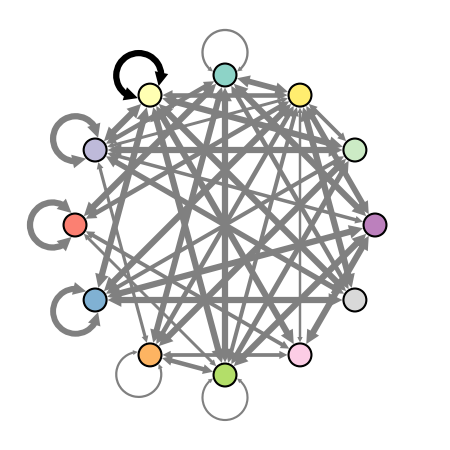

In [38]:
K = K_random[m][KID]

save = True

fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=np.expand_dims(np.hstack((K,np.ones(m-num_inputs))),axis=0), # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimerID]]), # Index of output dimer
                                        ncols = 1, # Number of columns in figure
                                        r_node = 1, # Radius of nodes around center
                                        r_loop = 0.15, # Radius of loops around nodes 
                                        node_scales = [-3,3,12,12], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        K_edge_scales = [-4,3,1,3], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        fontsize=9, # Font size
                                        input_cmap=plt.get_cmap('Set3'),
                                        non_output_dimer_color='gray',
                                        fontname='Helvetica',
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
                                        labels=False,
)

fig.set_dpi(150)

if save:
    filename = f'versatility_example_schematic_{m}m_{KID}K_{dimerID}dimer'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')